# Regressed Feature Comparison

## Import

### Import modules

In [1]:
import theano
import statsmodels.api as sm
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import time
from __future__ import division
import theano.tensor as T
from scipy.stats import ks_2samp
import scipy.misc
import seaborn as sns
sns.set_style("white")
import os
import sys
sys.path.append('../')
from Regression_Application import *
sys.path.append('../../../modules')
from MPPlot import *
from Processors import *

/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using Theano backend.


### Import data
Here just looking at mu tau_h b b final-state

In [2]:
mode = "mu_tau_b_b"
loc = '../../../../data_n/'
SignalData = []
BackgroundData = []

energies = ['260', '270', '280', '320', '300','400','500', '550', '600' , '700']
backgrounds = ['TT' , 'WJetsToLNu']
Data = np.concatenate((energies,backgrounds))

def backgroundName(background):
    if background == 'TT':
        return loc + 'TT_TuneCUETP8M1_13TeV-powheg-pythia8_2.csv'
    elif background == 'WJetsToLNu':
        return loc + 'WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8.csv'



 #Load data from CSV files
for energy in energies:
    signaldata = pandas.read_csv(loc + "GluGluToRadionToHHTo2B2Tau_M-" + str(energy) +"_narrow_13TeV-madgraph.csv")
    signaldata['gen_label'] = energy
    SignalData.append(signaldata)


for back in backgrounds:
    backgroundData = pandas.read_csv(backgroundName(back))
    backgroundData['gen_label'] = back
    BackgroundData.append(backgroundData)    
     
    
signalData = SignalData[0]
for signal_data in SignalData[1:]:
    signalData = signalData.append(signal_data, ignore_index=True)    
signalData.drop([x for x in signalData.columns if 'Unnamed' in x], axis=1, inplace=True)    
signalData['gen_target'] = pandas.Series(np.ones(signalData.size))
backgroundData = BackgroundData[0]
for background_data in BackgroundData[1:]:
    backgroundData = backgroundData.append(background_data, ignore_index=True)    
backgroundData.drop([x for x in backgroundData.columns if 'Unnamed' in x], axis=1, inplace=True)    
backgroundData['gen_target'] = pandas.Series(np.zeros(backgroundData.size))

print("Samples contains {0} signal events and {1} background events".format(len(signalData), len(backgroundData)))
print("{} events in total".format(len(signalData)+len(backgroundData)))
data = signalData.append(backgroundData, ignore_index = True) #Combine into signal dataset


def abs_(x):
    if type(x) is float:
        return abs(x)
    else:
        return x

def cleanData(X):
    """
    Recives data and labels (X and y)
    
    Returns: X, y after removing points that would fail to convert to float32 
    """
    X.applymap(abs_)
    
    
    over  = (X > np.finfo(np.float32).max)
    under = (X < np.finfo(np.float32).min)
    selecting = pandas.Series(np.zeros(len(X)), dtype=np.bool)

    for label in over.columns:
        if label != 'gen_label':
            selecting = selecting | over[label] | under[label]
    
    
    X = X[np.logical_not(selecting)].reset_index(drop=True)#.values.astype('float32')
    
    return X

data = cleanData(data)

Samples contains 10417 signal events and 168053 background events
178470 events in total


## Configure data

### Move to cartesian coordinates

In [3]:
particles = ['t_0', 't_1', 'b_0', 'b_1', 'h_tt', 'h_bb', 'diH', 'gen_t_0', 'gen_t_1', 'gen_b_0' ,'gen_b_1']

for p in particles:
    moveToCartesian(data, p) #Move pT, eta, and phi to p_x, p_y, and p_z
    if(not str.startswith(p, "gen")):
        addEnergy(data, p) #Calculate energy and absolute momentum


moveToCartesian(data, 'mPT', False)  #Move Missing pT and phi to p_x and p_y
addAbsMom(data, 'mPT', False) #Calculate absolute missing transverse momentum
addMT(data, data['t_1_pT'], data['t_1_phi'], 't_1') #Calculate transverse mass of tau_mu
addHighLvl(data)
data['hl_mT'] = np.sqrt(2*data['t_1_pT']*data['mPT_pT']*(1-np.cos(deltaphi(data['t_1_phi'], data['mPT_phi']))))

In [16]:
sig_devIndeces, sig_valIndeces = \
                train_test_split([i for i in data[(data.gen_target == 1) & (data.gen_mctMatch == 1)].index.tolist()],
                                 test_size=0.2, random_state=1337)

    
devData = data.loc[sig_devIndeces].copy()
#devData = devData.append(data.loc[bkg_devIndeces].copy(), ignore_index = True)
valData = data.loc[sig_valIndeces].copy()
valData = valData.append(data[data.gen_target == 0].copy(), ignore_index = True)
valData = valData.append(data[(data.gen_target == 1) & (data.gen_mctMatch == 0)].copy(), ignore_index = True)
sig = (valData.gen_target == 1) & (valData.gen_mctMatch == 1)
bkg = (valData.gen_target == 0)
sigMM = (valData.gen_target == 1) & (valData.gen_mctMatch == 0)

print("{} events for training, {} events for validation".format(len(devData), len(valData)))


3928 events for training, 174533 events for validation


## Apply regressors

In [5]:
btrain = ['t_0_mass', 't_1_mass', 'b_0_mass', 'b_0_csv', 'b_1_mass', 'b_1_csv', 'mT', 'hT', 'sT', 'centrality', 'eVis', 't_0_px', 't_0_py', 't_0_pz', 't_0_|p|', 't_0_E', 't_1_px', 't_1_py', 't_1_pz', 't_1_|p|', 't_1_E', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_0_|p|', 'b_0_E', 'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_|p|', 'b_1_E', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT', 'hl_dpx_b_0_b_1', 'hl_dpy_b_0_b_1', 'hl_dpz_b_0_b_1', 'hl_dpx_b_0_t_0', 'hl_dpy_b_0_t_0', 'hl_dpz_b_0_t_0', 'hl_dpx_b_0_t_1', 'hl_dpy_b_0_t_1', 'hl_dpz_b_0_t_1', 'hl_dpx_b_0_mPT', 'hl_dpy_b_0_mPT', 'hl_dpx_b_1_b_0', 'hl_dpy_b_1_b_0', 'hl_dpz_b_1_b_0', 'hl_dpx_b_1_t_0', 'hl_dpy_b_1_t_0', 'hl_dpz_b_1_t_0', 'hl_dpx_b_1_t_1', 'hl_dpy_b_1_t_1', 'hl_dpz_b_1_t_1', 'hl_dpx_b_1_mPT', 'hl_dpy_b_1_mPT', 'hl_dpx_t_0_b_0', 'hl_dpy_t_0_b_0', 'hl_dpz_t_0_b_0', 'hl_dpx_t_0_b_1', 'hl_dpy_t_0_b_1', 'hl_dpz_t_0_b_1', 'hl_dpx_t_0_t_1', 'hl_dpy_t_0_t_1', 'hl_dpz_t_0_t_1', 'hl_dpx_t_0_mPT', 'hl_dpy_t_0_mPT', 'hl_dpx_t_1_b_0', 'hl_dpy_t_1_b_0', 'hl_dpz_t_1_b_0', 'hl_dpx_t_1_b_1', 'hl_dpy_t_1_b_1', 'hl_dpz_t_1_b_1', 'hl_dpx_t_1_t_0', 'hl_dpy_t_1_t_0', 'hl_dpz_t_1_t_0', 'hl_dpx_t_1_mPT', 'hl_dpy_t_1_mPT', 'hl_dpx_diH_h_bb', 'hl_dpy_diH_h_bb', 'hl_dpz_diH_h_bb', 'hl_dpx_diH_h_tt', 'hl_dpy_diH_h_tt', 'hl_dpz_diH_h_tt', 'hl_dpx_diH_mPT', 'hl_dpy_diH_mPT', 'hl_dpx_h_bb_diH', 'hl_dpy_h_bb_diH', 'hl_dpz_h_bb_diH', 'hl_dpx_h_bb_h_tt', 'hl_dpy_h_bb_h_tt', 'hl_dpz_h_bb_h_tt', 'hl_dpx_h_bb_mPT', 'hl_dpy_h_bb_mPT', 'hl_dpx_h_tt_diH', 'hl_dpy_h_tt_diH', 'hl_dpz_h_tt_diH', 'hl_dpx_h_tt_h_bb', 'hl_dpy_h_tt_h_bb', 'hl_dpz_h_tt_h_bb', 'hl_dpx_h_tt_mPT', 'hl_dpy_h_tt_mPT', 'hl_mT', 'h_tt_mass', 'h_tt_svFit_mass', 'h_bb_mass', 'diH_mass', 'diH_kinFit_mass', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_|p|', 'h_tt_E', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_|p|', 'h_bb_E', 'diH_px', 'diH_py', 'diH_pz', 'diH_|p|', 'diH_E', 'hl_mT']
bRegressor = BPairRegressor(data, "./bRegression/weights/NN_B_Regressor_App_" + mode + "_"  , mode , btrain)
bRegressor.evalResponse()
bRegressor.getExtraVariables()
bRegressor.refineDiHiggsVector()

KeyboardInterrupt: 

In [6]:
ttrain = ['t_0_mass', 't_1_mass', 'b_0_mass', 'b_0_csv', 'b_1_mass', 'b_1_csv', 'mT', 'hT', 'sT', 'centrality', 'eVis', 't_0_px', 't_0_py', 't_0_pz', 't_0_|p|', 't_0_E', 't_1_px', 't_1_py', 't_1_pz', 't_1_|p|', 't_1_E', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT', 'hl_dpx_b_0_b_1', 'hl_dpy_b_0_b_1', 'hl_dpz_b_0_b_1', 'hl_dpx_b_0_t_0', 'hl_dpy_b_0_t_0', 'hl_dpz_b_0_t_0', 'hl_dpx_b_0_t_1', 'hl_dpy_b_0_t_1', 'hl_dpz_b_0_t_1', 'hl_dpx_b_0_mPT', 'hl_dpy_b_0_mPT', 'hl_dpx_b_1_b_0', 'hl_dpy_b_1_b_0', 'hl_dpz_b_1_b_0', 'hl_dpx_b_1_t_0', 'hl_dpy_b_1_t_0', 'hl_dpz_b_1_t_0', 'hl_dpx_b_1_t_1', 'hl_dpy_b_1_t_1', 'hl_dpz_b_1_t_1', 'hl_dpx_b_1_mPT', 'hl_dpy_b_1_mPT', 'hl_dpx_t_0_b_0', 'hl_dpy_t_0_b_0', 'hl_dpz_t_0_b_0', 'hl_dpx_t_0_b_1', 'hl_dpy_t_0_b_1', 'hl_dpz_t_0_b_1', 'hl_dpx_t_0_t_1', 'hl_dpy_t_0_t_1', 'hl_dpz_t_0_t_1', 'hl_dpx_t_0_mPT', 'hl_dpy_t_0_mPT', 'hl_dpx_t_1_b_0', 'hl_dpy_t_1_b_0', 'hl_dpz_t_1_b_0', 'hl_dpx_t_1_b_1', 'hl_dpy_t_1_b_1', 'hl_dpz_t_1_b_1', 'hl_dpx_t_1_t_0', 'hl_dpy_t_1_t_0', 'hl_dpz_t_1_t_0', 'hl_dpx_t_1_mPT', 'hl_dpy_t_1_mPT', 'hl_dpx_diH_h_bb', 'hl_dpy_diH_h_bb', 'hl_dpz_diH_h_bb', 'hl_dpx_diH_h_tt', 'hl_dpy_diH_h_tt', 'hl_dpz_diH_h_tt', 'hl_dpx_diH_mPT', 'hl_dpy_diH_mPT', 'hl_dpx_h_bb_diH', 'hl_dpy_h_bb_diH', 'hl_dpz_h_bb_diH', 'hl_dpx_h_bb_h_tt', 'hl_dpy_h_bb_h_tt', 'hl_dpz_h_bb_h_tt', 'hl_dpx_h_bb_mPT', 'hl_dpy_h_bb_mPT', 'hl_dpx_h_tt_diH', 'hl_dpy_h_tt_diH', 'hl_dpz_h_tt_diH', 'hl_dpx_h_tt_h_bb', 'hl_dpy_h_tt_h_bb', 'hl_dpz_h_tt_h_bb', 'hl_dpx_h_tt_mPT', 'hl_dpy_h_tt_mPT', 'hl_mT', 'regB_b_0_px', 'regB_b_0_py', 'regB_b_0_pz', 'regB_b_1_px', 'regB_b_1_py', 'regB_b_1_pz', 'regB_b_0_|p|', 'regB_b_0_E', 'regB_b_1_|p|', 'regB_b_1_E', 'regB_h_bb_px', 'regB_h_bb_py', 'regB_h_bb_pz', 'regB_h_bb_E', 'regB_h_bb_|p|', 'regB_h_bb_mass', 'regB_diH_px', 'regB_diH_py', 'regB_diH_pz', 'regB_diH_E', 'regB_diH_|p|', 'regB_diH_mass', 'h_tt_mass', 'h_tt_svFit_mass', 'diH_kinFit_mass', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_|p|', 'h_tt_E', 'hl_mT']
tauRegressor = TauPairRegressor(data, "./tauRegression/weights/NN_Tau_Regressor_App_" + mode + "_"  , mode, ttrain )
tauRegressor.evalResponse()
tauRegressor.getExtraVariables()
tauRegressor.refineDiHiggsVector()

10 components found in ensemble


UnicodeDecodeError: 'ascii' codec can't decode byte 0x94 in position 3: ordinal not in range(128)

In [7]:
hhmtrain = ['t_0_mass', 'b_0_mass', 'b_0_csv', 'b_1_mass', 'b_1_csv', 'mT', 'hT', 'sT', 'centrality', 'eVis', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT', 'hl_dpx_b_0_b_1', 'hl_dpy_b_0_b_1', 'hl_dpz_b_0_b_1', 'hl_dpx_b_0_t_0', 'hl_dpy_b_0_t_0', 'hl_dpz_b_0_t_0', 'hl_dpx_b_0_t_1', 'hl_dpy_b_0_t_1', 'hl_dpz_b_0_t_1', 'hl_dpx_b_0_mPT', 'hl_dpy_b_0_mPT', 'hl_dpx_b_1_b_0', 'hl_dpy_b_1_b_0', 'hl_dpz_b_1_b_0', 'hl_dpx_b_1_t_0', 'hl_dpy_b_1_t_0', 'hl_dpz_b_1_t_0', 'hl_dpx_b_1_t_1', 'hl_dpy_b_1_t_1', 'hl_dpz_b_1_t_1', 'hl_dpx_b_1_mPT', 'hl_dpy_b_1_mPT', 'hl_dpx_t_0_b_0', 'hl_dpy_t_0_b_0', 'hl_dpz_t_0_b_0', 'hl_dpx_t_0_b_1', 'hl_dpy_t_0_b_1', 'hl_dpz_t_0_b_1', 'hl_dpx_t_0_t_1', 'hl_dpy_t_0_t_1', 'hl_dpz_t_0_t_1', 'hl_dpx_t_0_mPT', 'hl_dpy_t_0_mPT', 'hl_dpx_t_1_b_0', 'hl_dpy_t_1_b_0', 'hl_dpz_t_1_b_0', 'hl_dpx_t_1_b_1', 'hl_dpy_t_1_b_1', 'hl_dpz_t_1_b_1', 'hl_dpx_t_1_t_0', 'hl_dpy_t_1_t_0', 'hl_dpz_t_1_t_0', 'hl_dpx_t_1_mPT', 'hl_dpy_t_1_mPT', 'hl_dpx_diH_h_bb', 'hl_dpy_diH_h_bb', 'hl_dpz_diH_h_bb', 'hl_dpx_diH_h_tt', 'hl_dpy_diH_h_tt', 'hl_dpz_diH_h_tt', 'hl_dpx_diH_mPT', 'hl_dpy_diH_mPT', 'hl_dpx_h_bb_diH', 'hl_dpy_h_bb_diH', 'hl_dpz_h_bb_diH', 'hl_dpx_h_bb_h_tt', 'hl_dpy_h_bb_h_tt', 'hl_dpz_h_bb_h_tt', 'hl_dpx_h_bb_mPT', 'hl_dpy_h_bb_mPT', 'hl_dpx_h_tt_diH', 'hl_dpy_h_tt_diH', 'hl_dpz_h_tt_diH', 'hl_dpx_h_tt_h_bb', 'hl_dpy_h_tt_h_bb', 'hl_dpz_h_tt_h_bb', 'hl_dpx_h_tt_mPT', 'hl_dpy_h_tt_mPT', 'hl_mT', 'regB_b_0_px', 'regB_b_0_py', 'regB_b_0_pz', 'regB_b_1_px', 'regB_b_1_py', 'regB_b_1_pz', 'regB_b_0_|p|', 'regB_b_0_E', 'regB_b_1_|p|', 'regB_b_1_E', 'regB_h_bb_px', 'regB_h_bb_py', 'regB_h_bb_pz', 'regB_h_bb_E', 'regB_h_bb_|p|', 'regB_h_bb_mass', 'regTau_t_0_px', 'regTau_t_0_py', 'regTau_t_0_pz', 'regTau_t_1_px', 'regTau_t_1_py', 'regTau_t_1_pz', 'regTau_t_0_|p|', 'regTau_t_0_E', 'regTau_t_1_|p|', 'regTau_t_1_E', 'regTau_h_tt_px', 'regTau_h_tt_py', 'regTau_h_tt_pz', 'regTau_h_tt_E', 'regTau_h_tt_|p|', 'regTau_h_tt_mass', 'regTau_diH_px', 'regTau_diH_py', 'regTau_diH_pz', 'regTau_diH_E', 'regTau_diH_|p|', 'regTau_diH_mass', 'h_tt_svFit_mass', 'diH_kinFit_mass', 'hl_mT']
hhMomRegressor = HHMomRegressor(data, "./hhMomRegression/weights/NN_HH_Mom_Regressor_App_" + mode + "_" , mode, hhmtrain)
hhMomRegressor.evalResponse()
hhMomRegressor.getExtraVariables()

In [8]:
hhtrain = ['t_0_mass', 't_1_mass', 'b_0_mass', 'b_0_csv', 'b_1_mass', 'b_1_csv', 'mT', 'hT', 'sT', 'centrality', 'eVis', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT', 'hl_dpx_b_0_b_1', 'hl_dpy_b_0_b_1', 'hl_dpz_b_0_b_1', 'hl_dpx_b_0_t_0', 'hl_dpy_b_0_t_0', 'hl_dpz_b_0_t_0', 'hl_dpx_b_0_t_1', 'hl_dpy_b_0_t_1', 'hl_dpz_b_0_t_1', 'hl_dpx_b_0_mPT', 'hl_dpy_b_0_mPT', 'hl_dpx_b_1_b_0', 'hl_dpy_b_1_b_0', 'hl_dpz_b_1_b_0', 'hl_dpx_b_1_t_0', 'hl_dpy_b_1_t_0', 'hl_dpz_b_1_t_0', 'hl_dpx_b_1_t_1', 'hl_dpy_b_1_t_1', 'hl_dpz_b_1_t_1', 'hl_dpx_b_1_mPT', 'hl_dpy_b_1_mPT', 'hl_dpx_t_0_b_0', 'hl_dpy_t_0_b_0', 'hl_dpz_t_0_b_0', 'hl_dpx_t_0_b_1', 'hl_dpy_t_0_b_1', 'hl_dpz_t_0_b_1', 'hl_dpx_t_0_t_1', 'hl_dpy_t_0_t_1', 'hl_dpz_t_0_t_1', 'hl_dpx_t_0_mPT', 'hl_dpy_t_0_mPT', 'hl_dpx_t_1_b_0', 'hl_dpy_t_1_b_0', 'hl_dpz_t_1_b_0', 'hl_dpx_t_1_b_1', 'hl_dpy_t_1_b_1', 'hl_dpz_t_1_b_1', 'hl_dpx_t_1_t_0', 'hl_dpy_t_1_t_0', 'hl_dpz_t_1_t_0', 'hl_dpx_t_1_mPT', 'hl_dpy_t_1_mPT', 'hl_dpx_diH_h_bb', 'hl_dpy_diH_h_bb', 'hl_dpz_diH_h_bb', 'hl_dpx_diH_h_tt', 'hl_dpy_diH_h_tt', 'hl_dpz_diH_h_tt', 'hl_dpx_diH_mPT', 'hl_dpy_diH_mPT', 'hl_dpx_h_bb_diH', 'hl_dpy_h_bb_diH', 'hl_dpz_h_bb_diH', 'hl_dpx_h_bb_h_tt', 'hl_dpy_h_bb_h_tt', 'hl_dpz_h_bb_h_tt', 'hl_dpx_h_bb_mPT', 'hl_dpy_h_bb_mPT', 'hl_dpx_h_tt_diH', 'hl_dpy_h_tt_diH', 'hl_dpz_h_tt_diH', 'hl_dpx_h_tt_h_bb', 'hl_dpy_h_tt_h_bb', 'hl_dpz_h_tt_h_bb', 'hl_dpx_h_tt_mPT', 'hl_dpy_h_tt_mPT', 'hl_mT', 'regB_b_0_px', 'regB_b_0_py', 'regB_b_0_pz', 'regB_b_1_px', 'regB_b_1_py', 'regB_b_1_pz', 'regB_b_0_|p|', 'regB_b_0_E', 'regB_b_1_|p|', 'regB_b_1_E', 'regB_h_bb_px', 'regB_h_bb_py', 'regB_h_bb_pz', 'regB_h_bb_E', 'regB_h_bb_|p|', 'regB_h_bb_mass', 'regTau_t_0_px', 'regTau_t_0_py', 'regTau_t_0_pz', 'regTau_t_1_px', 'regTau_t_1_py', 'regTau_t_1_pz', 'regTau_t_0_|p|', 'regTau_t_0_E', 'regTau_t_1_|p|', 'regTau_t_1_E', 'regTau_h_tt_px', 'regTau_h_tt_py', 'regTau_h_tt_pz', 'regTau_h_tt_E', 'regTau_h_tt_|p|', 'regTau_h_tt_mass', 'regHH_diH_px', 'regHH_diH_py', 'regHH_diH_pz', 'regHH_diH_|p|', 'regHH_diH_E', 'h_tt_svFit_mass', 'diH_kinFit_mass', 'hl_mT', 'regTau_diH_mass']
hhRegressor = HHRegressor(data, "./hhRegression/weights/NN_HH_Regressor_App_" + mode + "_"  , mode, hhtrain)
hhRegressor.evalResponse()
hhRegressor.getExtraVariables()

In [12]:
hBBRegressor = HBBMassRegressor(data, "./bRegression/weights/NN_B_Regressor_SO_App_" + mode + "_", mode)
hBBRegressor.evalResponse()
hBBRegressor.getExtraVariables()

0
1
(2, 'components found in ensemble')
0
1
(2, 'components found in ensemble')


In [19]:
hTTRegressor = HTTMassRegressor(data, "./tauRegression/weights/NN_Tauh_Regressor_SO_App_" + mode + "_" ,
                                "./tauRegression/weights/NN_Taumu_Regressor_SO_App_" + mode + "_"  , mode)
#hTTRegressor.evalResponse()
#hTTRegressor.getExtraVariables()
hTTRegressor.refineDiHiggsVector()

(2, 'components found in ensemble')
(2, 'components found in ensemble')


In [5]:
hhmtrain = ['t_0_mass', 'b_0_mass', 'b_0_csv', 'b_1_mass', 'b_1_csv', 'mT', 'hT', 'sT', 'centrality', 'eVis', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT', 'regHBB_b_0_px', 'regHBB_b_0_py', 'regHBB_b_0_pz', 'regHBB_b_1_px', 'regHBB_b_1_py', 'regHBB_b_1_pz', 'regHBB_b_0_|p|', 'regHBB_b_0_E', 'regHBB_b_1_|p|', 'regHBB_b_1_E', 'regHBB_h_bb_px', 'regHBB_h_bb_py', 'regHBB_h_bb_pz', 'regHBB_h_bb_E', 'regHBB_h_bb_|p|', 'regHBB_h_bb_mass', 'regHTT_t_0_px', 'regHTT_t_0_py', 'regHTT_t_0_pz', 'regHTT_t_1_px', 'regHTT_t_1_py', 'regHTT_t_1_pz', 'regHTT_t_0_|p|', 'regHTT_t_0_E', 'regHTT_t_1_|p|', 'regHTT_t_1_E', 'regHTT_h_tt_px', 'regHTT_h_tt_py', 'regHTT_h_tt_pz', 'regHTT_h_tt_E', 'regHTT_h_tt_|p|', 'regHTT_h_tt_mass', 'h_tt_svFit_mass', 'diH_mass', 'diH_kinFit_mass', 'diH_px', 'diH_py', 'diH_pz', 'diH_|p|', 'diH_E', 'hl_mT']
hhmomRegressor = HHMomRegressor(data, "./hhMomRegression/weights/NN_HH_Mom_Regressor_App_SO" + mode + "_"  , mode, hhmtrain)
hhmomRegressor.evalResponse()
hhmomRegressor.getExtraVariables()

(10, 'components found in ensemble')


In [6]:
hhtrain = ['t_0_mass', 't_1_mass', 'b_0_mass', 'b_0_csv', 'b_1_mass', 'b_1_csv', 'mT', 'hT', 'sT', 'centrality', 'eVis', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT', 'regHBB_b_0_px', 'regHBB_b_0_py', 'regHBB_b_0_pz', 'regHBB_b_1_px', 'regHBB_b_1_py', 'regHBB_b_1_pz', 'regHBB_b_0_|p|', 'regHBB_b_0_E', 'regHBB_b_1_|p|', 'regHBB_b_1_E', 'regHBB_h_bb_px', 'regHBB_h_bb_py', 'regHBB_h_bb_pz', 'regHBB_h_bb_E', 'regHBB_h_bb_|p|', 'regHBB_h_bb_mass', 'regHTT_t_0_px', 'regHTT_t_0_py', 'regHTT_t_0_pz', 'regHTT_t_1_px', 'regHTT_t_1_py', 'regHTT_t_1_pz', 'regHTT_t_0_|p|', 'regHTT_t_0_E', 'regHTT_t_1_|p|', 'regHTT_t_1_E', 'regHTT_h_tt_px', 'regHTT_h_tt_py', 'regHTT_h_tt_pz', 'regHTT_h_tt_E', 'regHTT_h_tt_|p|', 'regHTT_h_tt_mass', 'regHH_diH_px', 'regHH_diH_py', 'regHH_diH_pz', 'regHH_diH_|p|', 'regHH_diH_E', 'h_tt_svFit_mass', 'diH_mass', 'diH_kinFit_mass', 'hl_mT']
sohhRegressor = SO_HHRegressor(data, "./hhRegression/weights/NN_HH_Regressor_App_SO" + mode + "_"  , mode, hhtrain)
sohhRegressor.evalResponse()
sohhRegressor.getExtraVariables()

(10, 'components found in ensemble')


In [ ]:
bRegressor = None
tauRegressor = None
hhMomRegressor = None
hhRegressor = None
hBBRegressor = None
hTTRegressor = None

### Save processed data

In [14]:
data.to_csv(loc +'/fullData.csv')

### Load processed data

In [3]:
data = pandas.read_csv(loc + '/fullData.csv')

/home/goncalo/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<function matplotlib.pyplot.show>

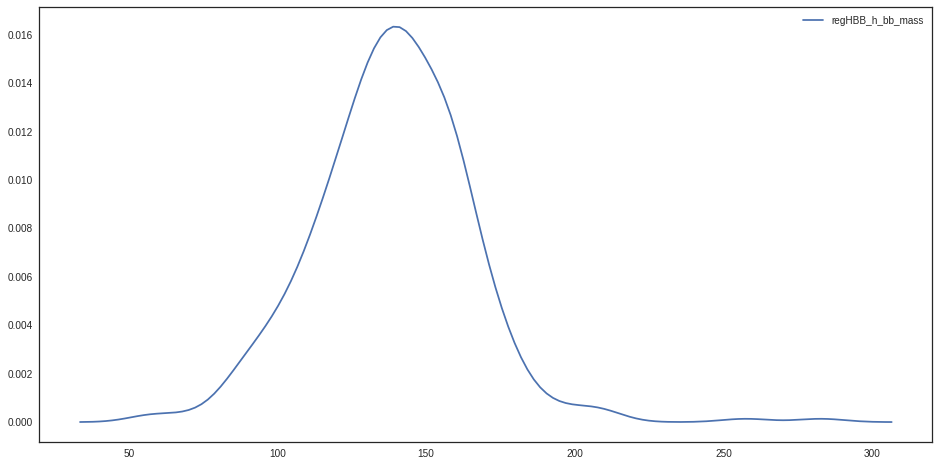

In [14]:
#devData['test' + 'px'] = devData.loc[:, "regHBB_h_bb_" + 'px']+devData.loc[:, 'regHTT_h_tt_' + 'px']
#devData['test' + 'py'] = devData.loc[:, "regHBB_h_bb_" + 'py']+devData.loc[:, 'regHTT_h_tt_' + 'py']
#devData['test' + 'pz'] = devData.loc[:, "regHBB_h_bb_" + 'pz']+devData.loc[:, 'regHTT_h_tt_' + 'pz']
#devData['test' + 'E'] = devData.loc[:, "regHBB_h_bb_" + 'E']+devData.loc[:, 'regHTT_h_tt_' + 'E']
#devData['test' + '|p|'] = np.sqrt(np.square(devData.loc[:, 'test' + 'px'])+np.square(devData.loc[:, 'test' + 'py'])+np.square(devData.loc[:, 'test' + 'pz']))
#devData['test' + 'mass'] = np.sqrt(np.square(devData.loc[:, 'test' + 'E'])-np.square(devData.loc[:, 'test' + '|p|'])) 
plt.figure(figsize=(16, 8))

sns.kdeplot(data = devData.loc[sig,'regHBB_h_bb_mass'])

plt.show

### Specify features

In [11]:
for i in data.columns:
    print (i)

Unnamed: 0
Unnamed: 0.1
Unnamed: 0.1.1
Unnamed: 0.1.1
t_0_pT
t_0_eta
t_0_phi
t_0_mass
t_1_pT
t_1_eta
t_1_phi
t_1_mass
b_0_pT
b_0_eta
b_0_phi
b_0_mass
b_0_csv
b_1_pT
b_1_eta
b_1_phi
b_1_mass
b_1_csv
mPT_pT
mPT_phi
h_tt_pT
h_tt_eta
h_tt_phi
h_tt_mass
h_tt_svFit_mass
h_bb_pT
h_bb_eta
h_bb_phi
h_bb_mass
diH_pT
diH_eta
diH_phi
diH_mass
diH_kinFit_mass
diH_kinFit_prob
mT
hT
sT
centrality
eVis
sphericity
spherocity
aplanarity
aplanority
upsilon
dShape
sphericityEigen0
sphericityEigen1
sphericityEigen2
spherocityEigen0
spherocityEigen1
spherocityEigen2
gen_t_0_pT
gen_t_0_eta
gen_t_0_phi
gen_t_0_E
gen_t_1_pT
gen_t_1_eta
gen_t_1_phi
gen_t_1_E
gen_b_0_pT
gen_b_0_eta
gen_b_0_phi
gen_b_0_E
gen_b_1_pT
gen_b_1_eta
gen_b_1_phi
gen_b_1_E
gen_diH_pT
gen_diH_eta
gen_diH_phi
gen_diH_E
gen_diH_mass
gen_h_bb_pT
gen_h_bb_eta
gen_h_bb_phi
gen_h_bb_E
gen_h_tt_pT
gen_h_tt_eta
gen_h_tt_phi
gen_h_tt_E
gen_mctMatch
gen_weight
gen_label
gen_target
t_0_px
t_0_py
t_0_pz
t_0_|p|
t_0_E
t_1_px
t_1_py
t_1_pz
t_1_|p|
t_1_

In [5]:
genFeatures = [gen for gen in data.columns if str.startswith(gen, "gen")]
trainFeatures = [var for var in data.columns if var not in genFeatures]

## Create development and validation samples

In [6]:
data.rename(columns={'weight': 'gen_weight'}, inplace=True)
genFeatures = [gen for gen in data.columns if str.startswith(gen, "gen")]
trainFeatures = [var for var in data.columns if var not in genFeatures]
pTEtaPhi = [var for var in trainFeatures for x in ['pT', 'eta', 'phi'] if x in var]
other = [var for var in trainFeatures for x in [ 'prob'] if x in var]
trainFeatures = [var for var in trainFeatures if var not in pTEtaPhi + other]

In [7]:
shapes = [var for var in trainFeatures for x in ['aplan', 'dShape', 'spher', 'upsilon'] if x in var]
shapeFeatures = [var for var in trainFeatures if var in shapes]
eventKinematicFeatures = ['centrality', 'eVis', 'hT', 'sT','mT']
jetFeatures = [var for var in trainFeatures if 'Jet' in var and 'Jets' not in var]
multiplicityFeatures = ['nBJets', 'nJets', 'nPhotons', 'nTauJets']
hlFeatures = [var for var in trainFeatures if (str.startswith(var, "hl_"))]
recoFeatures = [var for var in trainFeatures if (str.startswith(var, "h_")) or (str.startswith(var, "diH_"))]
regFeatures = [var for var in trainFeatures if (str.startswith(var, "reg"))]
regBFeatures = [var for var in trainFeatures if (str.startswith(var, "regB_"))]
regTauFeatures = [var for var in trainFeatures if (str.startswith(var, "regTau_"))]
regHHMomFeatures = [var for var in trainFeatures if (str.startswith(var, "regHH_"))]
regBDiHiggs = [var for var in regBFeatures if (str.startswith(var, "regB_diH_"))]
regTauDiHiggs = [var for var in regTauFeatures if (str.startswith(var, "regTau_diH_"))]
diHiggsFeatures = [var for var in trainFeatures if (str.startswith(var, "diH_"))]
regBasis = [var[var.find("_")+1:] for var in regFeatures]
massFeatures = [var for var in trainFeatures if "_mass" in var]
epFeatures = [var for var in trainFeatures if (str.endswith(var, "_E")) or (str.endswith(var, "_|p|"))]
fsFeatures =  [var for var in trainFeatures if var not in  shapeFeatures + pTEtaPhi  + recoFeatures]
reducedFSFeatures = [var for var in fsFeatures if var not in regBasis]
reducedRecoFeatures = [var for var in recoFeatures if var not in regBasis]


In [8]:
set0 = [var for var in fsFeatures + recoFeatures if var not in pTEtaPhi + regBFeatures + regTauFeatures + regHHMomFeatures] + ['hl_mT']
set1 = [var for var in reducedFSFeatures + reducedRecoFeatures if var not in pTEtaPhi + regBDiHiggs + regHHMomFeatures] + ['hl_mT']
set2 = [var for var in reducedFSFeatures + reducedRecoFeatures if var not in pTEtaPhi + regBDiHiggs + regTauDiHiggs + shapeFeatures] + ['hl_mT'] + ['regTau_diH_mass']

In [9]:
regTrainFeatures = set2
regModel = 'model0'
normIn = True
normOut = True
pca = True
whiten = False
nSplits = 10
cvTests = True
ensembleSize = 10
ensembleMode = 'loss'
regTargetFeatures = ['gen_diH_mass']
print ("\nTraining on", len(regTrainFeatures), "features:", [var for var in regTrainFeatures])
print ("\nRegressing to", len(regTargetFeatures), "features:", [var for var in regTargetFeatures])

('\nTraining on', 159, 'features:', ['Unnamed: 0', 't_0_mass', 't_1_mass', 'b_0_mass', 'b_0_csv', 'b_1_mass', 'b_1_csv', 'mT', 'hT', 'sT', 'centrality', 'eVis', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT', 'hl_dpx_b_0_b_1', 'hl_dpy_b_0_b_1', 'hl_dpz_b_0_b_1', 'hl_dpx_b_0_t_0', 'hl_dpy_b_0_t_0', 'hl_dpz_b_0_t_0', 'hl_dpx_b_0_t_1', 'hl_dpy_b_0_t_1', 'hl_dpz_b_0_t_1', 'hl_dpx_b_0_mPT', 'hl_dpy_b_0_mPT', 'hl_dpx_b_1_b_0', 'hl_dpy_b_1_b_0', 'hl_dpz_b_1_b_0', 'hl_dpx_b_1_t_0', 'hl_dpy_b_1_t_0', 'hl_dpz_b_1_t_0', 'hl_dpx_b_1_t_1', 'hl_dpy_b_1_t_1', 'hl_dpz_b_1_t_1', 'hl_dpx_b_1_mPT', 'hl_dpy_b_1_mPT', 'hl_dpx_t_0_b_0', 'hl_dpy_t_0_b_0', 'hl_dpz_t_0_b_0', 'hl_dpx_t_0_b_1', 'hl_dpy_t_0_b_1', 'hl_dpz_t_0_b_1', 'hl_dpx_t_0_t_1', 'hl_dpy_t_0_t_1', 'hl_dpz_t_0_t_1', 'hl_dpx_t_0_mPT', 'hl_dpy_t_0_mPT', 'hl_dpx_t_1_b_0', 'hl_dpy_t_1_b_0', 'hl_dpz_t_1_b_0', 'hl_dpx_t_1_b_1', 'hl_dpy_t_1_b_1', 'hl_dpz_t_1_b_1', 'hl_dpx_t_1_t_0', 'hl_dpy_t_1_t_0', 'hl_dpz_t_1_t_0', 'hl_dpx_t_1_mPT', 'hl_dpy_t_1_mPT', 'hl_dp

In [15]:

tmpData['reg_hh_px'] = data.loc[:,'regHBB_h_bb_px']+data.loc[:,'regHTT_h_tt_px']
tmpData['reg_hh_py'] = data.loc[:,'regHBB_h_bb_py']+data.loc[:,'regHTT_h_tt_py']
tmpData['reg_hh_pz'] = data.loc[:,'regHBB_h_bb_pz']+data.loc[:,'regHTT_h_tt_pz']
tmpData['reg_hh_E'] = data.loc[:,'regHBB_h_bb_E']+data.loc[:,'regHTT_h_tt_E']
tmpData['reg_hh_p2'] = np.square(tmpData.loc[:,'reg_hh_px'])+np.square(tmpData.loc[:,'reg_hh_py'])+np.square(tmpData.loc[:,'reg_hh_pz'])
tmpData['reg_hh_mass'] = np.sqrt(np.square(tmpData.loc[:,'reg_hh_E'])-tmpData.loc[:,'reg_hh_p2'])
data['calc_diH_mass'] = tmpData['reg_hh_mass']

## b-quarks

In [11]:
bMomFeats = ['b_0_px', 'b_0_py', 'b_0_pz', 'b_1_px', 'b_1_py', 'b_1_pz']

### Momenta distributions

In [12]:
"""pltArgs = []
for n, feature in enumerate(bMomFeats):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    if '_1_' in feature:
        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]
        if 'pz' in feature:
            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]
    pltArgs += [{'data':valData.loc[sigVal, "gen_" + feature], 'x':xPlot, 'name':'gen_' + feature, 'kde':1},
                {'data':valData.loc[sigVal, feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1},
                {'data':valData.loc[sigVal, "regB_" + feature], 'x':xPlot, 'name':'regB_' + feature, 'kde':1},
                ]
plots = mpRun(pltArgs)"""

'pltArgs = []\nfor n, feature in enumerate(bMomFeats):\n    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]\n    if \'pz\' in feature:\n        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]\n    if \'_1_\' in feature:\n        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]\n        if \'pz\' in feature:\n            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]\n    pltArgs += [{\'data\':valData.loc[sigVal, "gen_" + feature], \'x\':xPlot, \'name\':\'gen_\' + feature, \'kde\':1},\n                {\'data\':valData.loc[sigVal, feature], \'x\':xPlot, \'name\':\'rec_\' + feature, \'kde\':1},\n                {\'data\':valData.loc[sigVal, "regB_" + feature], \'x\':xPlot, \'name\':\'regB_\' + feature, \'kde\':1},\n                ]\nplots = mpRun(pltArgs)'

In [13]:
"""for n, feature in enumerate(bMomFeats):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    if '_1_' in feature:
        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]
        if 'pz' in feature:
            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]
    plt.figure(figsize=(8, 6))    
    sns.kdeplot(data=valData.loc[sigVal, feature])
    sns.kdeplot(data=valData.loc[sigVal, "gen_" + feature])
    sns.kdeplot(data=valData.loc[sigVal, "regB_" + feature])
    var = "p_{x,b_0}"
    if "py" in feature:
        var = "p_{y,b_0}"
    if "pz" in feature:
        var = "p_{z,b_0}"
    if "_1_" in feature:
        var = var[:-2] + "1}"
    plt.xlabel(r"$" + var + r"\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d" + var + r"}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()"""

'for n, feature in enumerate(bMomFeats):\n    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]\n    if \'pz\' in feature:\n        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]\n    if \'_1_\' in feature:\n        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]\n        if \'pz\' in feature:\n            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]\n    plt.figure(figsize=(8, 6))    \n    sns.kdeplot(data=valData.loc[sigVal, feature])\n    sns.kdeplot(data=valData.loc[sigVal, "gen_" + feature])\n    sns.kdeplot(data=valData.loc[sigVal, "regB_" + feature])\n    var = "p_{x,b_0}"\n    if "py" in feature:\n        var = "p_{y,b_0}"\n    if "pz" in feature:\n        var = "p_{z,b_0}"\n    if "_1_" in feature:\n        var = var[:-2] + "1}"\n    plt.xlabel(r"$" + var + r"\\ [GeV]$", fontsize=24, color=\'black\')\n    plt.ylabel(r"$\x0crac{1}{N}\\ \x0crac{dN}{d" + var + r"}\\ [GeV^{-1}]$", fontsize=24, color=\'black\')\nplt.show()'

### Delta distributions

In [14]:
"""pltArgs = []
for n, feature in enumerate(bMomFeats):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    var = "p_{x,b_0"
    if "py" in feature:
        var = "p_{y,b_0"
    if "pz" in feature:
        var = "p_{z,b_0"
    if "_1_" in feature:
        var = var[:-1] + "1"
    pltArgs += [{'data':valData.ix[sigVal, feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1, 'mean':1, 'std':1},
                {'data':valData.ix[sigVal, 'regB_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regB_' + feature, 'kde':1, 'mean':1, 'std':1},
               {'data':valData.ix[sigVal, 'regHBB_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regHBB_' + feature, 'kde':1, 'mean':1, 'std':1}]
plots = mpRun(pltArgs)"""

'pltArgs = []\nfor n, feature in enumerate(bMomFeats):\n    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]\n    if \'pz\' in feature:\n        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]\n    var = "p_{x,b_0"\n    if "py" in feature:\n        var = "p_{y,b_0"\n    if "pz" in feature:\n        var = "p_{z,b_0"\n    if "_1_" in feature:\n        var = var[:-1] + "1"\n    pltArgs += [{\'data\':valData.ix[sigVal, feature]-valData.ix[sigVal, \'gen_\' + feature], \'x\':xPlot, \'name\':\'rec_\' + feature, \'kde\':1, \'mean\':1, \'std\':1},\n                {\'data\':valData.ix[sigVal, \'regB_\' + feature]-valData.ix[sigVal, \'gen_\' + feature], \'x\':xPlot, \'name\':\'regB_\' + feature, \'kde\':1, \'mean\':1, \'std\':1},\n               {\'data\':valData.ix[sigVal, \'regHBB_\' + feature]-valData.ix[sigVal, \'gen_\' + feature], \'x\':xPlot, \'name\':\'regHBB_\' + feature, \'kde\':1, \'mean\':1, \'std\':1}]\nplots = mpRun(pltArgs)'

In [15]:
"""for n, feature in enumerate(bMomFeats):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    var = "p_{x,b_0"
    if "py" in feature:
        var = "p_{y,b_0"
    if "pz" in feature:
        var = "p_{z,b_0"
    if "_1_" in feature:
        var = var[:-1] + "1"
    plt.figure(figsize=(8, 6))
    mean = (np.mean(plots['rec_' + feature + '_mean']),
            np.std(plots['rec_' + feature + '_mean'])/math.sqrt(len(plots['rec_' + feature + '_mean'])))
    stdev = (np.mean(plots['rec_' + feature + '_std']),
             np.std(plots['rec_' + feature + '_std'])/math.sqrt(len(plots['rec_' + feature + '_std'])))
    print "Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['rec_' + feature + '_kde'], time=xPlot,
               condition=r'Reconstructed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='g')
    mean = (np.mean(plots['regHBB_' + feature + '_mean']),
            np.std(plots['regHBB_' + feature + '_mean'])/math.sqrt(len(plots['regHBB_' + feature + '_mean'])))
    stdev = (np.mean(plots['regHBB_' + feature + '_std']),
             np.std(plots['regHBB_' + feature + '_std'])/math.sqrt(len(plots['regHBB_' + feature + '_std'])))
    print "Reg Single:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['regHBB_' + feature + '_kde'], time=xPlot,
               condition=r'B SO Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='OrangeRed')
    mean = (np.mean(plots['regB_' + feature + '_mean']),
            np.std(plots['regB_' + feature + '_mean'])/math.sqrt(len(plots['regB_' + feature + '_mean'])))
    stdev = (np.mean(plots['regB_' + feature + '_std']),
             np.std(plots['regB_' + feature + '_std'])/math.sqrt(len(plots['regB_' + feature + '_std'])))
    print "Reg Pair:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['regB_' + feature + '_kde'], time=xPlot,
               condition=r'B Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='m')
    plt.legend(fontsize=16)
    plt.xlabel(r"$" + var + r",\mathrm{Est.}}-" + var + r",\mathrm{True}}\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\Delta " + var + r"}}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()"""

'for n, feature in enumerate(bMomFeats):\n    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]\n    if \'pz\' in feature:\n        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]\n    var = "p_{x,b_0"\n    if "py" in feature:\n        var = "p_{y,b_0"\n    if "pz" in feature:\n        var = "p_{z,b_0"\n    if "_1_" in feature:\n        var = var[:-1] + "1"\n    plt.figure(figsize=(8, 6))\n    mean = (np.mean(plots[\'rec_\' + feature + \'_mean\']),\n            np.std(plots[\'rec_\' + feature + \'_mean\'])/math.sqrt(len(plots[\'rec_\' + feature + \'_mean\'])))\n    stdev = (np.mean(plots[\'rec_\' + feature + \'_std\']),\n             np.std(plots[\'rec_\' + feature + \'_std\'])/math.sqrt(len(plots[\'rec_\' + feature + \'_std\'])))\n    print "Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])\n    sns.tsplot(data=plots[\'rec_\' + feature + \'_kde\'], time=xPlot,\n               condition=r\'Reconstructed,  $\\overline{\\Delta p}\' + r\'= {:.2f

### Two-sample Kolmogorov–Smirnov test

In [16]:
"""for n, feature in enumerate(bMomFeats):
    print 
    print feature
    ksTest = ks_2samp(valData[sigVal]['gen_' + feature].values, valData[sigVal]['regB_' + feature].values)
    print "K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1])"""

'for n, feature in enumerate(bMomFeats):\n    print \n    print feature\n    ksTest = ks_2samp(valData[sigVal][\'gen_\' + feature].values, valData[sigVal][\'regB_\' + feature].values)\n    print "K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1])'

## Tau-quarks

In [17]:
tauMomFeats = ['t_0_px', 't_0_py', 't_0_pz', 't_1_px', 't_1_py', 't_1_pz']

### Momenta distributions

In [18]:
"""pltArgs = []
for n, feature in enumerate(tauMomFeats):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    if '_1_' in feature:
        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]
        if 'pz' in feature:
            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]
    pltArgs += [{'data':valData.ix[sigVal, "gen_" + feature], 'x':xPlot, 'name':'gen_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, "regTau_" + feature], 'x':xPlot, 'name':'regTau_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, "regHTT_" + feature], 'x':xPlot, 'name':'regHTT_' + feature, 'kde':1}]
plots = mpRun(pltArgs)"""

'pltArgs = []\nfor n, feature in enumerate(tauMomFeats):\n    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]\n    if \'pz\' in feature:\n        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]\n    if \'_1_\' in feature:\n        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]\n        if \'pz\' in feature:\n            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]\n    pltArgs += [{\'data\':valData.ix[sigVal, "gen_" + feature], \'x\':xPlot, \'name\':\'gen_\' + feature, \'kde\':1},\n                {\'data\':valData.ix[sigVal, feature], \'x\':xPlot, \'name\':\'rec_\' + feature, \'kde\':1},\n                {\'data\':valData.ix[sigVal, "regTau_" + feature], \'x\':xPlot, \'name\':\'regTau_\' + feature, \'kde\':1},\n                {\'data\':valData.ix[sigVal, "regHTT_" + feature], \'x\':xPlot, \'name\':\'regHTT_\' + feature, \'kde\':1}]\nplots = mpRun(pltArgs)'

In [19]:
"""for n, feature in enumerate(tauMomFeats):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    if '_1_' in feature:
        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]
        if 'pz' in feature:
            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]
    plt.figure(figsize=(8, 6))    
    sns.tsplot(data=plots['rec_' + feature + '_kde'], time=xPlot, condition='Reconstructed', color='g')
    sns.tsplot(data=plots['regHTT_' + feature + '_kde'], time=xPlot, condition='Tau single-Regressed', color='DarkMagenta')
    sns.tsplot(data=plots['gen_' + feature + '_kde'], time=xPlot, condition='True', color='b')
    sns.tsplot(data=plots['regTau_' + feature + '_kde'], time=xPlot, condition='Tau pair-Regressed', color='c')
    plt.legend(fontsize=16)
    var = r"p_{x,\tau_0}"
    if "py" in feature:
        var = r"p_{y,\tau_0}"
    if "pz" in feature:
        var = r"p_{z,\tau_0}"
    if "_1_" in feature:
        var = var[:-2] + "1}"
    plt.xlabel(r"$" + var + r"\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d" + var + r"}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()"""

'for n, feature in enumerate(tauMomFeats):\n    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]\n    if \'pz\' in feature:\n        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]\n    if \'_1_\' in feature:\n        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]\n        if \'pz\' in feature:\n            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]\n    plt.figure(figsize=(8, 6))    \n    sns.tsplot(data=plots[\'rec_\' + feature + \'_kde\'], time=xPlot, condition=\'Reconstructed\', color=\'g\')\n    sns.tsplot(data=plots[\'regHTT_\' + feature + \'_kde\'], time=xPlot, condition=\'Tau single-Regressed\', color=\'DarkMagenta\')\n    sns.tsplot(data=plots[\'gen_\' + feature + \'_kde\'], time=xPlot, condition=\'True\', color=\'b\')\n    sns.tsplot(data=plots[\'regTau_\' + feature + \'_kde\'], time=xPlot, condition=\'Tau pair-Regressed\', color=\'c\')\n    plt.legend(fontsize=16)\n    var = r"p_{x,\tau_0}"\n    if "py" in feature:\n        var = r"p_{y,\tau_0}"\n    if "

### Delta distributions

In [20]:
"""pltArgs = []
for n, feature in enumerate(tauMomFeats):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    pltArgs += [{'data':valData.ix[sigVal, feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1, 'mean':1, 'std':1},
                {'data':valData.ix[sigVal, 'regTau_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regTau_' + feature, 'kde':1, 'mean':1, 'std':1},
               {'data':valData.ix[sigVal, 'regHTT_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regHTT_' + feature, 'kde':1, 'mean':1, 'std':1}]
plots = mpRun(pltArgs)"""

"pltArgs = []\nfor n, feature in enumerate(tauMomFeats):\n    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]\n    if 'pz' in feature:\n        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]\n    pltArgs += [{'data':valData.ix[sigVal, feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1, 'mean':1, 'std':1},\n                {'data':valData.ix[sigVal, 'regTau_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regTau_' + feature, 'kde':1, 'mean':1, 'std':1},\n               {'data':valData.ix[sigVal, 'regHTT_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regHTT_' + feature, 'kde':1, 'mean':1, 'std':1}]\nplots = mpRun(pltArgs)"

In [21]:
"""for n, feature in enumerate(tauMomFeats):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    var = r"p_{x,\tau_0"
    if "py" in feature:
        var = r"p_{y,\tau_0"
    if "pz" in feature:
        var = r"p_{z,\tau_0"
    if "_1_" in feature:
        var = var[:-1] + "1"
    plt.figure(figsize=(8, 6))
    mean = (np.mean(plots['rec_' + feature + '_mean']),
            np.std(plots['rec_' + feature + '_mean'])/math.sqrt(len(plots['rec_' + feature + '_mean'])))
    stdev = (np.mean(plots['rec_' + feature + '_std']),
             np.std(plots['rec_' + feature + '_std'])/math.sqrt(len(plots['rec_' + feature + '_std'])))
    print "Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['rec_' + feature + '_kde'], time=xPlot,
               condition=r'Reconstructed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='g')
    mean = (np.mean(plots['regHTT_' + feature + '_mean']),
            np.std(plots['regHTT_' + feature + '_mean'])/math.sqrt(len(plots['regHTT_' + feature + '_mean'])))
    stdev = (np.mean(plots['regHTT_' + feature + '_std']),
             np.std(plots['regHTT_' + feature + '_std'])/math.sqrt(len(plots['regHTT_' + feature + '_std'])))
    print "Reg Single:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['regHTT_' + feature + '_kde'], time=xPlot,
               condition=r'Tau SO Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='DarkMagenta')
    mean = (np.mean(plots['regTau_' + feature + '_mean']),
            np.std(plots['regTau_' + feature + '_mean'])/math.sqrt(len(plots['regTau_' + feature + '_mean'])))
    stdev = (np.mean(plots['regTau_' + feature + '_std']),
             np.std(plots['regTau_' + feature + '_std'])/math.sqrt(len(plots['regTau_' + feature + '_std'])))
    print "Reg Pair:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['regTau_' + feature + '_kde'], time=xPlot,
               condition=r'Tau Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='c')
    plt.legend(fontsize=16)
    plt.xlabel(r"$" + var + r",\mathrm{Est.}}-" + var + r",\mathrm{True}}\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\Delta " + var + r"}}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()"""

'for n, feature in enumerate(tauMomFeats):\n    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]\n    if \'pz\' in feature:\n        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]\n    var = r"p_{x,\tau_0"\n    if "py" in feature:\n        var = r"p_{y,\tau_0"\n    if "pz" in feature:\n        var = r"p_{z,\tau_0"\n    if "_1_" in feature:\n        var = var[:-1] + "1"\n    plt.figure(figsize=(8, 6))\n    mean = (np.mean(plots[\'rec_\' + feature + \'_mean\']),\n            np.std(plots[\'rec_\' + feature + \'_mean\'])/math.sqrt(len(plots[\'rec_\' + feature + \'_mean\'])))\n    stdev = (np.mean(plots[\'rec_\' + feature + \'_std\']),\n             np.std(plots[\'rec_\' + feature + \'_std\'])/math.sqrt(len(plots[\'rec_\' + feature + \'_std\'])))\n    print "Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])\n    sns.tsplot(data=plots[\'rec_\' + feature + \'_kde\'], time=xPlot,\n               condition=r\'Reconstructed,  $\\overline{\\Delta p}\

### Two-sample Kolmogorov–Smirnov test

In [22]:
"""for n, feature in enumerate(tauMomFeats):
    print 
    print feature
    ksTest = ks_2samp(valData[sigVal]['gen_' + feature].values, valData[sigVal]['regTau_' + feature].values)
    print "K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1])"""

'for n, feature in enumerate(tauMomFeats):\n    print \n    print feature\n    ksTest = ks_2samp(valData[sigVal][\'gen_\' + feature].values, valData[sigVal][\'regTau_\' + feature].values)\n    print "K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1])'

## Higgs-> bb

In [23]:
hbbMomFeats = ['h_bb_px', 'h_bb_py', 'h_bb_pz']

### Momenta distributions

In [24]:
"""pltArgs = []
for n, feature in enumerate(hbbMomFeats):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    if '_1_' in feature:
        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]
        if 'pz' in feature:
            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]
    pltArgs += [{'data':valData.ix[sigVal, "gen_" + feature], 'x':xPlot, 'name':'gen_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, "regB_" + feature], 'x':xPlot, 'name':'regB_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, "regHBB_" + feature], 'x':xPlot, 'name':'regHBB_' + feature, 'kde':1}]
plots = mpRun(pltArgs)"""

'pltArgs = []\nfor n, feature in enumerate(hbbMomFeats):\n    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]\n    if \'pz\' in feature:\n        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]\n    if \'_1_\' in feature:\n        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]\n        if \'pz\' in feature:\n            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]\n    pltArgs += [{\'data\':valData.ix[sigVal, "gen_" + feature], \'x\':xPlot, \'name\':\'gen_\' + feature, \'kde\':1},\n                {\'data\':valData.ix[sigVal, feature], \'x\':xPlot, \'name\':\'rec_\' + feature, \'kde\':1},\n                {\'data\':valData.ix[sigVal, "regB_" + feature], \'x\':xPlot, \'name\':\'regB_\' + feature, \'kde\':1},\n                {\'data\':valData.ix[sigVal, "regHBB_" + feature], \'x\':xPlot, \'name\':\'regHBB_\' + feature, \'kde\':1}]\nplots = mpRun(pltArgs)'

In [25]:
"""for n, feature in enumerate(hbbMomFeats):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    plt.figure(figsize=(8, 6))    
    sns.tsplot(data=plots['rec_' + feature + '_kde'], time=xPlot, condition='Reconstructed', color='g')
    sns.tsplot(data=plots['regHBB_' + feature + '_kde'], time=xPlot, condition='B single-Regressed', color='OrangeRed')
    sns.tsplot(data=plots['gen_' + feature + '_kde'], time=xPlot, condition='True', color='b')
    sns.tsplot(data=plots['regB_' + feature + '_kde'], time=xPlot, condition='B pair-Regressed', color='m')
    plt.legend(fontsize=16)
    var = r"p_{x,h_{b\bar{b}}}"
    if "py" in feature:
        var = r"p_{y,h_{b\bar{b}}}"
    if "pz" in feature:
        var = r"p_{z,h_{b\bar{b}}}"
    plt.xlabel(r"$" + var + r"\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d" + var + r"}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()"""

'for n, feature in enumerate(hbbMomFeats):\n    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]\n    if \'pz\' in feature:\n        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]\n    plt.figure(figsize=(8, 6))    \n    sns.tsplot(data=plots[\'rec_\' + feature + \'_kde\'], time=xPlot, condition=\'Reconstructed\', color=\'g\')\n    sns.tsplot(data=plots[\'regHBB_\' + feature + \'_kde\'], time=xPlot, condition=\'B single-Regressed\', color=\'OrangeRed\')\n    sns.tsplot(data=plots[\'gen_\' + feature + \'_kde\'], time=xPlot, condition=\'True\', color=\'b\')\n    sns.tsplot(data=plots[\'regB_\' + feature + \'_kde\'], time=xPlot, condition=\'B pair-Regressed\', color=\'m\')\n    plt.legend(fontsize=16)\n    var = r"p_{x,h_{b\x08ar{b}}}"\n    if "py" in feature:\n        var = r"p_{y,h_{b\x08ar{b}}}"\n    if "pz" in feature:\n        var = r"p_{z,h_{b\x08ar{b}}}"\n    plt.xlabel(r"$" + var + r"\\ [GeV]$", fontsize=24, color=\'black\')\n    plt.ylabel(r"$\x0crac{1}{N}\\ \x0crac{dN}{

### Delta distributions

In [26]:
"""pltArgs = []
for n, feature in enumerate(hbbMomFeats):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    pltArgs += [{'data':valData.ix[sigVal, feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1, 'mean':1, 'std':1},
                {'data':valData.ix[sigVal, 'regB_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regB_' + feature, 'kde':1, 'mean':1, 'std':1},
               {'data':valData.ix[sigVal, 'regHBB_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regHBB_' + feature, 'kde':1, 'mean':1, 'std':1}]
plots = mpRun(pltArgs)"""

"pltArgs = []\nfor n, feature in enumerate(hbbMomFeats):\n    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]\n    if 'pz' in feature:\n        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]\n    pltArgs += [{'data':valData.ix[sigVal, feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1, 'mean':1, 'std':1},\n                {'data':valData.ix[sigVal, 'regB_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regB_' + feature, 'kde':1, 'mean':1, 'std':1},\n               {'data':valData.ix[sigVal, 'regHBB_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regHBB_' + feature, 'kde':1, 'mean':1, 'std':1}]\nplots = mpRun(pltArgs)"

In [27]:
"""for n, feature in enumerate(hbbMomFeats):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    var = r"p_{x,h_{b\bar{b}}"
    if "py" in feature:
        var = r"p_{y,h_{b\bar{b}}"
    if "pz" in feature:
        var = r"p_{z,h_{b\bar{b}}"
    plt.figure(figsize=(8, 6))
    mean = (np.mean(plots['rec_' + feature + '_mean']),
            np.std(plots['rec_' + feature + '_mean'])/math.sqrt(len(plots['rec_' + feature + '_mean'])))
    stdev = (np.mean(plots['rec_' + feature + '_std']),
             np.std(plots['rec_' + feature + '_std'])/math.sqrt(len(plots['rec_' + feature + '_std'])))
    print "Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['rec_' + feature + '_kde'], time=xPlot,
               condition=r'Reconstructed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='g')
    mean = (np.mean(plots['regHBB_' + feature + '_mean']),
            np.std(plots['regHBB_' + feature + '_mean'])/math.sqrt(len(plots['regHBB_' + feature + '_mean'])))
    stdev = (np.mean(plots['regHBB_' + feature + '_std']),
             np.std(plots['regHBB_' + feature + '_std'])/math.sqrt(len(plots['regHBB_' + feature + '_std'])))
    print "Reg Single:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['regHBB_' + feature + '_kde'], time=xPlot,
               condition=r'B SO Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='OrangeRed')
    mean = (np.mean(plots['regB_' + feature + '_mean']),
            np.std(plots['regB_' + feature + '_mean'])/math.sqrt(len(plots['regB_' + feature + '_mean'])))
    stdev = (np.mean(plots['regB_' + feature + '_std']),
             np.std(plots['regB_' + feature + '_std'])/math.sqrt(len(plots['regB_' + feature + '_std'])))
    print "Reg Pair:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['regB_' + feature + '_kde'], time=xPlot,
               condition=r'B Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='m')
    plt.legend(fontsize=16)
    plt.xlabel(r"$" + var + r",\mathrm{Est.}}-" + var + r",\mathrm{True}}\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\Delta " + var + r"}}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()"""

'for n, feature in enumerate(hbbMomFeats):\n    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]\n    if \'pz\' in feature:\n        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]\n    var = r"p_{x,h_{b\x08ar{b}}"\n    if "py" in feature:\n        var = r"p_{y,h_{b\x08ar{b}}"\n    if "pz" in feature:\n        var = r"p_{z,h_{b\x08ar{b}}"\n    plt.figure(figsize=(8, 6))\n    mean = (np.mean(plots[\'rec_\' + feature + \'_mean\']),\n            np.std(plots[\'rec_\' + feature + \'_mean\'])/math.sqrt(len(plots[\'rec_\' + feature + \'_mean\'])))\n    stdev = (np.mean(plots[\'rec_\' + feature + \'_std\']),\n             np.std(plots[\'rec_\' + feature + \'_std\'])/math.sqrt(len(plots[\'rec_\' + feature + \'_std\'])))\n    print "Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])\n    sns.tsplot(data=plots[\'rec_\' + feature + \'_kde\'], time=xPlot,\n               condition=r\'Reconstructed,  $\\overline{\\Delta p}\' + r\'= {:.2f}\\pm{:.2f}, \\sig

### Two-sample Kolmogorov–Smirnov test

In [28]:
"""for n, feature in enumerate(hbbMomFeats):
    print 
    print feature
    ksTest = ks_2samp(valData[sigVal]['gen_' + feature].values, valData[sigVal]['regB_' + feature].values)
    print "K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1])"""

'for n, feature in enumerate(hbbMomFeats):\n    print \n    print feature\n    ksTest = ks_2samp(valData[sigVal][\'gen_\' + feature].values, valData[sigVal][\'regB_\' + feature].values)\n    print "K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1])'

### Mass

In [29]:
"""xPlot = np.linspace(0, 300, 300)[:, np.newaxis]
plots = mpRun([{'data':valData.ix[sigVal, 'regB_h_bb_mass'], 'name':'regB', 'x':xPlot, 'kde':1, 'mean':1, 'std':1},
              {'data':valData.ix[sigVal, 'h_bb_mass'], 'name':'rec', 'x':xPlot, 'kde':1, 'mean':1, 'std':1},
              {'data':valData.ix[sigVal, 'regHBB_h_bb_mass'], 'name':'regHBB', 'x':xPlot, 'kde':1, 'mean':1, 'std':1}])
meanRegB = (np.mean(plots['regB_mean']), np.std(plots['regB_mean'])/math.sqrt(len((plots['regB_mean']))))
stdRegB = (np.mean(plots['regB_std']), np.std(plots['regB_std'])/math.sqrt(len(plots['regB_std'])))
meanRegHBB = (np.mean(plots['regHBB_mean']), np.std(plots['regHBB_mean'])/math.sqrt(len((plots['regHBB_mean']))))
stdRegHBB = (np.mean(plots['regHBB_std']), np.std(plots['regHBB_std'])/math.sqrt(len(plots['regHBB_std'])))
meanReco = (np.mean(plots['rec_mean']), np.std(plots['rec_mean'])/math.sqrt(len((plots['rec_mean']))))
stdReco = (np.mean(plots['rec_std']), np.std(plots['rec_std'])/math.sqrt(len(plots['rec_std'])))
print "Distribution\t\tmean\tsigma"
print 'B Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanRegB[0], meanRegB[1], stdRegB[0], stdRegB[1])
print 'B SO Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanRegHBB[0], meanRegHBB[1], stdRegHBB[0], stdRegHBB[1])
print 'Reconstructed Signal,  Mean = {:} +- {:}, sigma = {:} +- {:}'.format(meanReco[0], meanReco[1], stdReco[0], stdReco[1])"""

'xPlot = np.linspace(0, 300, 300)[:, np.newaxis]\nplots = mpRun([{\'data\':valData.ix[sigVal, \'regB_h_bb_mass\'], \'name\':\'regB\', \'x\':xPlot, \'kde\':1, \'mean\':1, \'std\':1},\n              {\'data\':valData.ix[sigVal, \'h_bb_mass\'], \'name\':\'rec\', \'x\':xPlot, \'kde\':1, \'mean\':1, \'std\':1},\n              {\'data\':valData.ix[sigVal, \'regHBB_h_bb_mass\'], \'name\':\'regHBB\', \'x\':xPlot, \'kde\':1, \'mean\':1, \'std\':1}])\nmeanRegB = (np.mean(plots[\'regB_mean\']), np.std(plots[\'regB_mean\'])/math.sqrt(len((plots[\'regB_mean\']))))\nstdRegB = (np.mean(plots[\'regB_std\']), np.std(plots[\'regB_std\'])/math.sqrt(len(plots[\'regB_std\'])))\nmeanRegHBB = (np.mean(plots[\'regHBB_mean\']), np.std(plots[\'regHBB_mean\'])/math.sqrt(len((plots[\'regHBB_mean\']))))\nstdRegHBB = (np.mean(plots[\'regHBB_std\']), np.std(plots[\'regHBB_std\'])/math.sqrt(len(plots[\'regHBB_std\'])))\nmeanReco = (np.mean(plots[\'rec_mean\']), np.std(plots[\'rec_mean\'])/math.sqrt(len((plots[\'rec_m

In [30]:
"""hist_params = {'shade' : False}
plt.figure(figsize=(16, 8))
sns.tsplot(data=plots['rec_kde'], time=xPlot, 
          condition=r'Reconstructed Signal,  $\overline{M_{h\rightarrow b\bar{b}}}' + r' = {:.2f}\pm{:.2f}, \sigma = {:.1f}\pm{:.1f}$'.format(meanReco[0], meanReco[1], stdReco[0], stdReco[1]),
          color='g')
sns.tsplot(data=plots['regB_kde'], time=xPlot, 
          condition=r'B Regressed Signal, $\overline{M_{h\rightarrow b\bar{b}}}' + r' = {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(meanRegB[0], meanRegB[1], stdRegB[0], stdRegB[1]),
          color='m')
sns.tsplot(data=plots['regHBB_kde'], time=xPlot, 
          condition=r'B SO Regressed Signal, $\overline{M_{h\rightarrow b\bar{b}}}' + r' = {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(meanRegHBB[0], meanRegHBB[1], stdRegHBB[0], stdRegHBB[1]),
          color='OrangeRed')
plt.legend(fontsize=16)
plt.xlabel(r'$M_{h\rightarrow b\bar{b}}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()"""

'hist_params = {\'shade\' : False}\nplt.figure(figsize=(16, 8))\nsns.tsplot(data=plots[\'rec_kde\'], time=xPlot, \n          condition=r\'Reconstructed Signal,  $\\overline{M_{h\rightarrow b\x08ar{b}}}\' + r\' = {:.2f}\\pm{:.2f}, \\sigma = {:.1f}\\pm{:.1f}$\'.format(meanReco[0], meanReco[1], stdReco[0], stdReco[1]),\n          color=\'g\')\nsns.tsplot(data=plots[\'regB_kde\'], time=xPlot, \n          condition=r\'B Regressed Signal, $\\overline{M_{h\rightarrow b\x08ar{b}}}\' + r\' = {:.2f}\\pm{:.2f}, \\sigma = {:.2f}\\pm{:.2f}$\'.format(meanRegB[0], meanRegB[1], stdRegB[0], stdRegB[1]),\n          color=\'m\')\nsns.tsplot(data=plots[\'regHBB_kde\'], time=xPlot, \n          condition=r\'B SO Regressed Signal, $\\overline{M_{h\rightarrow b\x08ar{b}}}\' + r\' = {:.2f}\\pm{:.2f}, \\sigma = {:.2f}\\pm{:.2f}$\'.format(meanRegHBB[0], meanRegHBB[1], stdRegHBB[0], stdRegHBB[1]),\n          color=\'OrangeRed\')\nplt.legend(fontsize=16)\nplt.xlabel(r\'$M_{h\rightarrow b\x08ar{b}}\\ [GeV]$\' , fon

In [31]:
"""xPlot = np.linspace(0, 300, 300)[:, np.newaxis]
plots = mpRun([{'data':valData.ix[bkgVal, 'regB_h_bb_mass'], 'x':xPlot, 'name':'bkg_regB', 'kde':1},
               {'data':valData.ix[sigVal, 'regB_h_bb_mass'], 'x':xPlot, 'name':'sig_regB', 'kde':1},
               {'data':valData.ix[bkgVal, 'regHBB_h_bb_mass'], 'x':xPlot, 'name':'bkg_regHBB', 'kde':1},
               {'data':valData.ix[sigVal, 'regHBB_h_bb_mass'], 'x':xPlot, 'name':'sig_regHBB', 'kde':1}])"""

"xPlot = np.linspace(0, 300, 300)[:, np.newaxis]\nplots = mpRun([{'data':valData.ix[bkgVal, 'regB_h_bb_mass'], 'x':xPlot, 'name':'bkg_regB', 'kde':1},\n               {'data':valData.ix[sigVal, 'regB_h_bb_mass'], 'x':xPlot, 'name':'sig_regB', 'kde':1},\n               {'data':valData.ix[bkgVal, 'regHBB_h_bb_mass'], 'x':xPlot, 'name':'bkg_regHBB', 'kde':1},\n               {'data':valData.ix[sigVal, 'regHBB_h_bb_mass'], 'x':xPlot, 'name':'sig_regHBB', 'kde':1}])"

In [32]:
"""plt.figure(figsize=(16, 8))
sns.tsplot(data=plots['bkg_regB' + '_kde'], time=xPlot, ci=[68, 95], color='m', linestyle="dashed", condition="B Regressed Background")
sns.tsplot(data=plots['bkg_regHBB' + '_kde'], time=xPlot, ci=[68, 95], color='OrangeRed', linestyle="dashed", condition="B SO Regressed Background")
sns.tsplot(data=plots['sig_regB' + '_kde'], time=xPlot, ci=[68, 95], color='m', condition="B Regressed Signal")
sns.tsplot(data=plots['sig_regHBB' + '_kde'], time=xPlot, ci=[68, 95], color='OrangeRed', condition="B SO Regressed Signal")
plt.legend(fontsize=16)
plt.xlabel(r'$M_{h\rightarrow b\bar{b}}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()"""

'plt.figure(figsize=(16, 8))\nsns.tsplot(data=plots[\'bkg_regB\' + \'_kde\'], time=xPlot, ci=[68, 95], color=\'m\', linestyle="dashed", condition="B Regressed Background")\nsns.tsplot(data=plots[\'bkg_regHBB\' + \'_kde\'], time=xPlot, ci=[68, 95], color=\'OrangeRed\', linestyle="dashed", condition="B SO Regressed Background")\nsns.tsplot(data=plots[\'sig_regB\' + \'_kde\'], time=xPlot, ci=[68, 95], color=\'m\', condition="B Regressed Signal")\nsns.tsplot(data=plots[\'sig_regHBB\' + \'_kde\'], time=xPlot, ci=[68, 95], color=\'OrangeRed\', condition="B SO Regressed Signal")\nplt.legend(fontsize=16)\nplt.xlabel(r\'$M_{h\rightarrow b\x08ar{b}}\\ [GeV]$\' , fontsize=24, color=\'black\')\nplt.ylabel(r"$\x0crac{1}{N}\\ \x0crac{dN}{d M}\\ [GeV^{-1}]$", fontsize=24, color=\'black\')\nplt.show()'

## Higgs-> TauTau

In [33]:
httMomFeats = ['h_tt_px', 'h_tt_py', 'h_tt_pz']

### Momenta distributions

In [34]:
"""pltArgs = []
for n, feature in enumerate(httMomFeats):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    if '_1_' in feature:
        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]
        if 'pz' in feature:
            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]
    pltArgs += [{'data':valData.ix[sigVal, "gen_" + feature], 'x':xPlot, 'name':'gen_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, "regTau_" + feature], 'x':xPlot, 'name':'regTau_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, "regHTT_" + feature], 'x':xPlot, 'name':'regHTT_' + feature, 'kde':1}]
plots = mpRun(pltArgs)"""

'pltArgs = []\nfor n, feature in enumerate(httMomFeats):\n    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]\n    if \'pz\' in feature:\n        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]\n    if \'_1_\' in feature:\n        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]\n        if \'pz\' in feature:\n            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]\n    pltArgs += [{\'data\':valData.ix[sigVal, "gen_" + feature], \'x\':xPlot, \'name\':\'gen_\' + feature, \'kde\':1},\n                {\'data\':valData.ix[sigVal, feature], \'x\':xPlot, \'name\':\'rec_\' + feature, \'kde\':1},\n                {\'data\':valData.ix[sigVal, "regTau_" + feature], \'x\':xPlot, \'name\':\'regTau_\' + feature, \'kde\':1},\n                {\'data\':valData.ix[sigVal, "regHTT_" + feature], \'x\':xPlot, \'name\':\'regHTT_\' + feature, \'kde\':1}]\nplots = mpRun(pltArgs)'

In [35]:
"""for n, feature in enumerate(httMomFeats):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    if '_1_' in feature:
        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]
        if 'pz' in feature:
            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]
    plt.figure(figsize=(8, 6))    
    sns.tsplot(data=plots['rec_' + feature + '_kde'], time=xPlot, condition='Reconstructed', color='g')
    sns.tsplot(data=plots['regHTT_' + feature + '_kde'], time=xPlot, condition='Tau single-Regressed', color='DarkMagenta')
    sns.tsplot(data=plots['gen_' + feature + '_kde'], time=xPlot, condition='True', color='b')
    sns.tsplot(data=plots['regTau_' + feature + '_kde'], time=xPlot, condition='Tau pair-Regressed', color='c')
    plt.legend(fontsize=16)
    var = r"p_{x,h_{\tau\bar{\tau}}}"
    if "py" in feature:
        var = r"p_{y,h_{\tau\bar{\tau}}}"
    if "pz" in feature:
        var = r"p_{z,h_{\tau\bar{\tau}}}"
    plt.xlabel(r"$" + var + r"\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d" + var + r"}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()"""

'for n, feature in enumerate(httMomFeats):\n    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]\n    if \'pz\' in feature:\n        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]\n    if \'_1_\' in feature:\n        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]\n        if \'pz\' in feature:\n            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]\n    plt.figure(figsize=(8, 6))    \n    sns.tsplot(data=plots[\'rec_\' + feature + \'_kde\'], time=xPlot, condition=\'Reconstructed\', color=\'g\')\n    sns.tsplot(data=plots[\'regHTT_\' + feature + \'_kde\'], time=xPlot, condition=\'Tau single-Regressed\', color=\'DarkMagenta\')\n    sns.tsplot(data=plots[\'gen_\' + feature + \'_kde\'], time=xPlot, condition=\'True\', color=\'b\')\n    sns.tsplot(data=plots[\'regTau_\' + feature + \'_kde\'], time=xPlot, condition=\'Tau pair-Regressed\', color=\'c\')\n    plt.legend(fontsize=16)\n    var = r"p_{x,h_{\tau\x08ar{\tau}}}"\n    if "py" in feature:\n        var = r"p_{y,h_{\

### Delta distributions

In [36]:
"""pltArgs = []
for n, feature in enumerate(httMomFeats):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    pltArgs += [{'data':valData.ix[sigVal, feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1, 'mean':1, 'std':1},
                {'data':valData.ix[sigVal, 'regTau_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regTau_' + feature, 'kde':1, 'mean':1, 'std':1},
                {'data':valData.ix[sigVal, 'regHTT_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regHTT_' + feature, 'kde':1, 'mean':1, 'std':1}]
plots = mpRun(pltArgs)"""

"pltArgs = []\nfor n, feature in enumerate(httMomFeats):\n    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]\n    if 'pz' in feature:\n        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]\n    pltArgs += [{'data':valData.ix[sigVal, feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1, 'mean':1, 'std':1},\n                {'data':valData.ix[sigVal, 'regTau_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regTau_' + feature, 'kde':1, 'mean':1, 'std':1},\n                {'data':valData.ix[sigVal, 'regHTT_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regHTT_' + feature, 'kde':1, 'mean':1, 'std':1}]\nplots = mpRun(pltArgs)"

In [37]:
"""for n, feature in enumerate(httMomFeats):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    var = r"p_{x,h_{\tau\bar{\tau}}"
    if "py" in feature:
        var = r"p_{y,h_{\tau\bar{\tau}}"
    if "pz" in feature:
        var = r"p_{z,h_{\tau\bar{\tau}}"
    plt.figure(figsize=(8, 6))
    mean = (np.mean(plots['rec_' + feature + '_mean']),
            np.std(plots['rec_' + feature + '_mean'])/math.sqrt(len(plots['rec_' + feature + '_mean'])))
    stdev = (np.mean(plots['rec_' + feature + '_std']),
             np.std(plots['rec_' + feature + '_std'])/math.sqrt(len(plots['rec_' + feature + '_std'])))
    print "Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['rec_' + feature + '_kde'], time=xPlot,
               condition=r'Reconstructed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='g')
    mean = (np.mean(plots['regHTT_' + feature + '_mean']),
            np.std(plots['regHTT_' + feature + '_mean'])/math.sqrt(len(plots['regHTT_' + feature + '_mean'])))
    stdev = (np.mean(plots['regHTT_' + feature + '_std']),
             np.std(plots['regHTT_' + feature + '_std'])/math.sqrt(len(plots['regHTT_' + feature + '_std'])))
    print "Reg Single:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['regHTT_' + feature + '_kde'], time=xPlot,
               condition=r'Tau SO Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='DarkMagenta')
    mean = (np.mean(plots['regTau_' + feature + '_mean']),
            np.std(plots['regTau_' + feature + '_mean'])/math.sqrt(len(plots['regTau_' + feature + '_mean'])))
    stdev = (np.mean(plots['regTau_' + feature + '_std']),
             np.std(plots['regTau_' + feature + '_std'])/math.sqrt(len(plots['regTau_' + feature + '_std'])))
    print "Reg Pair:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['regTau_' + feature + '_kde'], time=xPlot,
               condition=r'Tau Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='c')
    plt.legend(fontsize=16)
    plt.xlabel(r"$" + var + r",\mathrm{Est.}}-" + var + r",\mathrm{True}}\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\Delta " + var + r"}}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()"""

'for n, feature in enumerate(httMomFeats):\n    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]\n    if \'pz\' in feature:\n        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]\n    var = r"p_{x,h_{\tau\x08ar{\tau}}"\n    if "py" in feature:\n        var = r"p_{y,h_{\tau\x08ar{\tau}}"\n    if "pz" in feature:\n        var = r"p_{z,h_{\tau\x08ar{\tau}}"\n    plt.figure(figsize=(8, 6))\n    mean = (np.mean(plots[\'rec_\' + feature + \'_mean\']),\n            np.std(plots[\'rec_\' + feature + \'_mean\'])/math.sqrt(len(plots[\'rec_\' + feature + \'_mean\'])))\n    stdev = (np.mean(plots[\'rec_\' + feature + \'_std\']),\n             np.std(plots[\'rec_\' + feature + \'_std\'])/math.sqrt(len(plots[\'rec_\' + feature + \'_std\'])))\n    print "Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])\n    sns.tsplot(data=plots[\'rec_\' + feature + \'_kde\'], time=xPlot,\n               condition=r\'Reconstructed,  $\\overline{\\Delta p}\' + r\'= {:.2f

### Two-sample Kolmogorov–Smirnov test

In [38]:
"""for n, feature in enumerate(httMomFeats):
    print 
    print feature
    ksTest = ks_2samp(valData[sigVal]['gen_' + feature].values, valData[sigVal]['regTau_' + feature].values)
    print "K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1])"""

'for n, feature in enumerate(httMomFeats):\n    print \n    print feature\n    ksTest = ks_2samp(valData[sigVal][\'gen_\' + feature].values, valData[sigVal][\'regTau_\' + feature].values)\n    print "K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1])'

### Mass

In [39]:
"""xPlot = np.linspace(0, 300, 300)[:, np.newaxis]
plots = mpRun([{'data':valData.ix[sigVal, 'regTau_h_tt_mass'], 'name':'regTau', 'x':xPlot, 'kde':1, 'mean':1, 'std':1},
              {'data':valData.ix[sigVal, 'h_tt_mass'], 'name':'rec', 'x':xPlot, 'kde':1, 'mean':1, 'std':1},
              {'data':valData.ix[sigVal, 'regHTT_h_tt_mass'], 'name':'regHTT', 'x':xPlot, 'kde':1, 'mean':1, 'std':1}])
meanRegTau = (np.mean(plots['regTau_mean']), np.std(plots['regTau_mean'])/math.sqrt(len((plots['regTau_mean']))))
stdRegTau = (np.mean(plots['regTau_std']), np.std(plots['regTau_std'])/math.sqrt(len(plots['regTau_std'])))
meanRegHTT = (np.mean(plots['regHTT_mean']), np.std(plots['regHTT_mean'])/math.sqrt(len((plots['regHTT_mean']))))
stdRegHTT = (np.mean(plots['regHTT_std']), np.std(plots['regHTT_std'])/math.sqrt(len(plots['regHTT_std'])))
meanReco = (np.mean(plots['rec_mean']), np.std(plots['rec_mean'])/math.sqrt(len((plots['rec_mean']))))
stdReco = (np.mean(plots['rec_std']), np.std(plots['rec_std'])/math.sqrt(len(plots['rec_std'])))
print "Distribution\t\tmean\tsigma"
print 'Tau Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanRegTau[0], meanRegTau[1], stdRegTau[0], stdRegTau[1])
print 'Tau SO Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanRegHTT[0], meanRegHTT[1], stdRegHTT[0], stdRegHTT[1])
print 'Reconstructed Signal,  Mean = {:} +- {:}, sigma = {:} +- {:}'.format(meanReco[0], meanReco[1], stdReco[0], stdReco[1])"""

'xPlot = np.linspace(0, 300, 300)[:, np.newaxis]\nplots = mpRun([{\'data\':valData.ix[sigVal, \'regTau_h_tt_mass\'], \'name\':\'regTau\', \'x\':xPlot, \'kde\':1, \'mean\':1, \'std\':1},\n              {\'data\':valData.ix[sigVal, \'h_tt_mass\'], \'name\':\'rec\', \'x\':xPlot, \'kde\':1, \'mean\':1, \'std\':1},\n              {\'data\':valData.ix[sigVal, \'regHTT_h_tt_mass\'], \'name\':\'regHTT\', \'x\':xPlot, \'kde\':1, \'mean\':1, \'std\':1}])\nmeanRegTau = (np.mean(plots[\'regTau_mean\']), np.std(plots[\'regTau_mean\'])/math.sqrt(len((plots[\'regTau_mean\']))))\nstdRegTau = (np.mean(plots[\'regTau_std\']), np.std(plots[\'regTau_std\'])/math.sqrt(len(plots[\'regTau_std\'])))\nmeanRegHTT = (np.mean(plots[\'regHTT_mean\']), np.std(plots[\'regHTT_mean\'])/math.sqrt(len((plots[\'regHTT_mean\']))))\nstdRegHTT = (np.mean(plots[\'regHTT_std\']), np.std(plots[\'regHTT_std\'])/math.sqrt(len(plots[\'regHTT_std\'])))\nmeanReco = (np.mean(plots[\'rec_mean\']), np.std(plots[\'rec_mean\'])/math.sqr

In [40]:
"""hist_params = {'shade' : False}
plt.figure(figsize=(16, 8))
sns.tsplot(data=plots['rec_kde'], time=xPlot, 
          condition=r'Reconstructed Signal,  $\overline{M_{h\rightarrow \tau\bar{\tau}}}' + r' = {:.2f}\pm{:.2f}, \sigma = {:.1f}\pm{:.1f}$'.format(meanReco[0], meanReco[1], stdReco[0], stdReco[1]),
          color='g')
sns.tsplot(data=plots['regTau_kde'], time=xPlot, 
          condition=r'Tau Regressed Signal, $\overline{M_{h\rightarrow \tau\bar{\tau}}}' + r' = {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(meanRegTau[0], meanRegTau[1], stdRegTau[0], stdRegTau[1]),
          color='c')
sns.tsplot(data=plots['regHTT_kde'], time=xPlot, 
          condition=r'Tau SO Regressed Signal, $\overline{M_{h\rightarrow \tau\bar{\tau}}}' + r' = {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(meanRegHTT[0], meanRegHTT[1], stdRegHTT[0], stdRegHTT[1]),
          color='DarkMagenta')
plt.legend(fontsize=16)
plt.xlabel(r'$M_{h\rightarrow \tau\bar{\tau}}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()"""

'hist_params = {\'shade\' : False}\nplt.figure(figsize=(16, 8))\nsns.tsplot(data=plots[\'rec_kde\'], time=xPlot, \n          condition=r\'Reconstructed Signal,  $\\overline{M_{h\rightarrow \tau\x08ar{\tau}}}\' + r\' = {:.2f}\\pm{:.2f}, \\sigma = {:.1f}\\pm{:.1f}$\'.format(meanReco[0], meanReco[1], stdReco[0], stdReco[1]),\n          color=\'g\')\nsns.tsplot(data=plots[\'regTau_kde\'], time=xPlot, \n          condition=r\'Tau Regressed Signal, $\\overline{M_{h\rightarrow \tau\x08ar{\tau}}}\' + r\' = {:.2f}\\pm{:.2f}, \\sigma = {:.2f}\\pm{:.2f}$\'.format(meanRegTau[0], meanRegTau[1], stdRegTau[0], stdRegTau[1]),\n          color=\'c\')\nsns.tsplot(data=plots[\'regHTT_kde\'], time=xPlot, \n          condition=r\'Tau SO Regressed Signal, $\\overline{M_{h\rightarrow \tau\x08ar{\tau}}}\' + r\' = {:.2f}\\pm{:.2f}, \\sigma = {:.2f}\\pm{:.2f}$\'.format(meanRegHTT[0], meanRegHTT[1], stdRegHTT[0], stdRegHTT[1]),\n          color=\'DarkMagenta\')\nplt.legend(fontsize=16)\nplt.xlabel(r\'$M_{h\right

In [41]:
"""xPlot = np.linspace(0, 300, 300)[:, np.newaxis]
plots = mpRun([{'data':valData.ix[bkgVal, 'regTau_h_tt_mass'], 'x':xPlot, 'name':'bkg_regTau', 'kde':1},
               {'data':valData.ix[sigVal, 'regTau_h_tt_mass'], 'x':xPlot, 'name':'sig_regTau', 'kde':1},
               {'data':valData.ix[bkgVal, 'regHTT_h_tt_mass'], 'x':xPlot, 'name':'bkg_regHTT', 'kde':1},
               {'data':valData.ix[sigVal, 'regHTT_h_tt_mass'], 'x':xPlot, 'name':'sig_regHTT', 'kde':1}])"""

"xPlot = np.linspace(0, 300, 300)[:, np.newaxis]\nplots = mpRun([{'data':valData.ix[bkgVal, 'regTau_h_tt_mass'], 'x':xPlot, 'name':'bkg_regTau', 'kde':1},\n               {'data':valData.ix[sigVal, 'regTau_h_tt_mass'], 'x':xPlot, 'name':'sig_regTau', 'kde':1},\n               {'data':valData.ix[bkgVal, 'regHTT_h_tt_mass'], 'x':xPlot, 'name':'bkg_regHTT', 'kde':1},\n               {'data':valData.ix[sigVal, 'regHTT_h_tt_mass'], 'x':xPlot, 'name':'sig_regHTT', 'kde':1}])"

In [42]:
"""plt.figure(figsize=(16, 8))
sns.tsplot(data=plots['bkg_regTau' + '_kde'], time=xPlot, ci=[68, 95], color='c', linestyle="dashed", condition="Tau Regressed Background")
sns.tsplot(data=plots['bkg_regHTT' + '_kde'], time=xPlot, ci=[68, 95], color='DarkMagenta', linestyle="dashed", condition="Tau SO Regressed Background")
sns.tsplot(data=plots['sig_regTau' + '_kde'], time=xPlot, ci=[68, 95], color='c', condition="Tau Regressed Signal")
sns.tsplot(data=plots['sig_regHTT' + '_kde'], time=xPlot, ci=[68, 95], color='DarkMagenta', condition="Tau SO Regressed Signal")
plt.legend(fontsize=16)
plt.xlabel(r'$M_{h\rightarrow \tau\bar{\tau}}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()"""

'plt.figure(figsize=(16, 8))\nsns.tsplot(data=plots[\'bkg_regTau\' + \'_kde\'], time=xPlot, ci=[68, 95], color=\'c\', linestyle="dashed", condition="Tau Regressed Background")\nsns.tsplot(data=plots[\'bkg_regHTT\' + \'_kde\'], time=xPlot, ci=[68, 95], color=\'DarkMagenta\', linestyle="dashed", condition="Tau SO Regressed Background")\nsns.tsplot(data=plots[\'sig_regTau\' + \'_kde\'], time=xPlot, ci=[68, 95], color=\'c\', condition="Tau Regressed Signal")\nsns.tsplot(data=plots[\'sig_regHTT\' + \'_kde\'], time=xPlot, ci=[68, 95], color=\'DarkMagenta\', condition="Tau SO Regressed Signal")\nplt.legend(fontsize=16)\nplt.xlabel(r\'$M_{h\rightarrow \tau\x08ar{\tau}}\\ [GeV]$\' , fontsize=24, color=\'black\')\nplt.ylabel(r"$\x0crac{1}{N}\\ \x0crac{dN}{d M}\\ [GeV^{-1}]$", fontsize=24, color=\'black\')\nplt.show()'

## Di-Higgs

In [43]:
"""hhMomFeats = ['diH_px', 'diH_py', 'diH_pz']"""

"hhMomFeats = ['diH_px', 'diH_py', 'diH_pz']"

### Momenta distributions

In [44]:
"""pltArgs = []
for n, feature in enumerate(hhMomFeats):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    if '_1_' in feature:
        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]
        if 'pz' in feature:
            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]
    pltArgs += [{'data':valData.ix[sigVal, "gen_" + feature], 'x':xPlot, 'name':'gen_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, "regTau_" + feature], 'x':xPlot, 'name':'regTau_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, "regB_" + feature], 'x':xPlot, 'name':'regB_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, "regHH_" + feature], 'x':xPlot, 'name':'regHH_' + feature, 'kde':1}]
plots = mpRun(pltArgs)"""

'pltArgs = []\nfor n, feature in enumerate(hhMomFeats):\n    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]\n    if \'pz\' in feature:\n        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]\n    if \'_1_\' in feature:\n        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]\n        if \'pz\' in feature:\n            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]\n    pltArgs += [{\'data\':valData.ix[sigVal, "gen_" + feature], \'x\':xPlot, \'name\':\'gen_\' + feature, \'kde\':1},\n                {\'data\':valData.ix[sigVal, feature], \'x\':xPlot, \'name\':\'rec_\' + feature, \'kde\':1},\n                {\'data\':valData.ix[sigVal, "regTau_" + feature], \'x\':xPlot, \'name\':\'regTau_\' + feature, \'kde\':1},\n                {\'data\':valData.ix[sigVal, "regB_" + feature], \'x\':xPlot, \'name\':\'regB_\' + feature, \'kde\':1},\n                {\'data\':valData.ix[sigVal, "regHH_" + feature], \'x\':xPlot, \'name\':\'regHH_\' + feature, \'kde\':1}]\nplots = mpRun(pl

In [45]:
"""for n, feature in enumerate(hhMomFeats):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    if '_1_' in feature:
        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]
        if 'pz' in feature:
            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]
    plt.figure(figsize=(8, 6))    
    sns.tsplot(data=plots['rec_' + feature + '_kde'], time=xPlot, condition='Reconstructed', color='g')
    sns.tsplot(data=plots['regB_' + feature + '_kde'], time=xPlot, condition='B pair-Regressed', color='m')
    sns.tsplot(data=plots['regTau_' + feature + '_kde'], time=xPlot, condition='Tau pair-Regressed', color='c')
    sns.tsplot(data=plots['gen_' + feature + '_kde'], time=xPlot, condition='True', color='b')
    sns.tsplot(data=plots['regHH_' + feature + '_kde'], time=xPlot, condition='True', color='r')
    plt.legend(fontsize=16)
    var = r"p_{x,hh}"
    if "py" in feature:
        var = r"p_{y,hh}"
    if "pz" in feature:
        var = r"p_{z,hh}"
    plt.xlabel(r"$" + var + r"\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d" + var + r"}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()"""

'for n, feature in enumerate(hhMomFeats):\n    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]\n    if \'pz\' in feature:\n        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]\n    if \'_1_\' in feature:\n        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]\n        if \'pz\' in feature:\n            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]\n    plt.figure(figsize=(8, 6))    \n    sns.tsplot(data=plots[\'rec_\' + feature + \'_kde\'], time=xPlot, condition=\'Reconstructed\', color=\'g\')\n    sns.tsplot(data=plots[\'regB_\' + feature + \'_kde\'], time=xPlot, condition=\'B pair-Regressed\', color=\'m\')\n    sns.tsplot(data=plots[\'regTau_\' + feature + \'_kde\'], time=xPlot, condition=\'Tau pair-Regressed\', color=\'c\')\n    sns.tsplot(data=plots[\'gen_\' + feature + \'_kde\'], time=xPlot, condition=\'True\', color=\'b\')\n    sns.tsplot(data=plots[\'regHH_\' + feature + \'_kde\'], time=xPlot, condition=\'True\', color=\'r\')\n    plt.legend(fontsize=16)\n  

### Delta distributions

In [46]:
"""pltArgs = []
for n, feature in enumerate(hhMomFeats):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    pltArgs += [{'data':valData.ix[sigVal, feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1, 'mean':1, 'std':1},
                {'data':valData.ix[sigVal, 'regTau_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regTau_' + feature, 'kde':1, 'mean':1, 'std':1},
                {'data':valData.ix[sigVal, 'regB_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regB_' + feature, 'kde':1, 'mean':1, 'std':1},
                {'data':valData.ix[sigVal, 'regHH_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regHH_' + feature, 'kde':1, 'mean':1, 'std':1}]
plots = mpRun(pltArgs)"""

"pltArgs = []\nfor n, feature in enumerate(hhMomFeats):\n    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]\n    if 'pz' in feature:\n        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]\n    pltArgs += [{'data':valData.ix[sigVal, feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1, 'mean':1, 'std':1},\n                {'data':valData.ix[sigVal, 'regTau_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regTau_' + feature, 'kde':1, 'mean':1, 'std':1},\n                {'data':valData.ix[sigVal, 'regB_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regB_' + feature, 'kde':1, 'mean':1, 'std':1},\n                {'data':valData.ix[sigVal, 'regHH_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regHH_' + feature, 'kde':1, 'mean':1, 'std':1}]\nplots = mpRun(pltArgs)"

In [47]:
"""for n, feature in enumerate(hhMomFeats):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    var = r"p_{x,hh}"
    if "py" in feature:
        var = r"p_{y,hh}"
    if "pz" in feature:
        var = r"p_{z,hh}"
    plt.figure(figsize=(8, 6))
    mean = (np.mean(plots['rec_' + feature + '_mean']),
            np.std(plots['rec_' + feature + '_mean'])/math.sqrt(len(plots['rec_' + feature + '_mean'])))
    stdev = (np.mean(plots['rec_' + feature + '_std']),
             np.std(plots['rec_' + feature + '_std'])/math.sqrt(len(plots['rec_' + feature + '_std'])))
    print "Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['rec_' + feature + '_kde'], time=xPlot,
               condition=r'Reconstructed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='g')
    mean = (np.mean(plots['regB_' + feature + '_mean']),
            np.std(plots['regB_' + feature + '_mean'])/math.sqrt(len(plots['regB_' + feature + '_mean'])))
    stdev = (np.mean(plots['regB_' + feature + '_std']),
             np.std(plots['regB_' + feature + '_std'])/math.sqrt(len(plots['regB_' + feature + '_std'])))
    print "B Reg Pair:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['regB_' + feature + '_kde'], time=xPlot,
               condition=r'B Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='m')
    mean = (np.mean(plots['regTau_' + feature + '_mean']),
            np.std(plots['regTau_' + feature + '_mean'])/math.sqrt(len(plots['regTau_' + feature + '_mean'])))
    stdev = (np.mean(plots['regTau_' + feature + '_std']),
             np.std(plots['regTau_' + feature + '_std'])/math.sqrt(len(plots['regTau_' + feature + '_std'])))
    print "Tau Reg Pair:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['regTau_' + feature + '_kde'], time=xPlot,
               condition=r'Tau Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='c')
    mean = (np.mean(plots['regHH_' + feature + '_mean']),
            np.std(plots['regHH_' + feature + '_mean'])/math.sqrt(len(plots['regHH_' + feature + '_mean'])))
    stdev = (np.mean(plots['regHH_' + feature + '_std']),
             np.std(plots['regHH_' + feature + '_std'])/math.sqrt(len(plots['regHH_' + feature + '_std'])))
    print "HH Reg Pair:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['regHH_' + feature + '_kde'], time=xPlot,
               condition=r'HH Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='r')
    plt.legend(fontsize=16)
    plt.xlabel(r"$" + var + r",\mathrm{Est.}}-" + var + r",\mathrm{True}}\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\Delta " + var + r"}}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()"""

'for n, feature in enumerate(hhMomFeats):\n    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]\n    if \'pz\' in feature:\n        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]\n    var = r"p_{x,hh}"\n    if "py" in feature:\n        var = r"p_{y,hh}"\n    if "pz" in feature:\n        var = r"p_{z,hh}"\n    plt.figure(figsize=(8, 6))\n    mean = (np.mean(plots[\'rec_\' + feature + \'_mean\']),\n            np.std(plots[\'rec_\' + feature + \'_mean\'])/math.sqrt(len(plots[\'rec_\' + feature + \'_mean\'])))\n    stdev = (np.mean(plots[\'rec_\' + feature + \'_std\']),\n             np.std(plots[\'rec_\' + feature + \'_std\'])/math.sqrt(len(plots[\'rec_\' + feature + \'_std\'])))\n    print "Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])\n    sns.tsplot(data=plots[\'rec_\' + feature + \'_kde\'], time=xPlot,\n               condition=r\'Reconstructed,  $\\overline{\\Delta p}\' + r\'= {:.2f}\\pm{:.2f}, \\sigma = {:.2f}\\pm{:.2f}$\'.format(me

### Two-sample Kolmogorov–Smirnov test

In [48]:
"""for n, feature in enumerate(hhMomFeats):
    print 
    print feature
    ksTest = ks_2samp(valData[sigVal]['gen_' + feature].values, valData[sigVal]['regHH_' + feature].values)
    print "K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1])"""

'for n, feature in enumerate(hhMomFeats):\n    print \n    print feature\n    ksTest = ks_2samp(valData[sigVal][\'gen_\' + feature].values, valData[sigVal][\'regHH_\' + feature].values)\n    print "K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1])'

### Mass

In [6]:
xPlot = np.linspace(150, 1200, 1050)[:, np.newaxis]
plots = mpRun([{'data':valData.loc[sig, 'gen_diH_mass'], 'name':'gen', 'x':xPlot, 'kde':1},
               {'data':valData.loc[sig, 'regTau_diH_mass'], 'name':'regTau', 'x':xPlot, 'kde':1},
               {'data':valData.loc[sig, 'diH_mass'], 'name':'rec', 'x':xPlot, 'kde':1},
               {'data':valData.loc[sig, 'regB_diH_mass'], 'name':'regB', 'x':xPlot, 'kde':1},
               {'data':valData.loc[sig, 'regHH_diH_mass'], 'name':'regHH', 'x':xPlot, 'kde':1}])

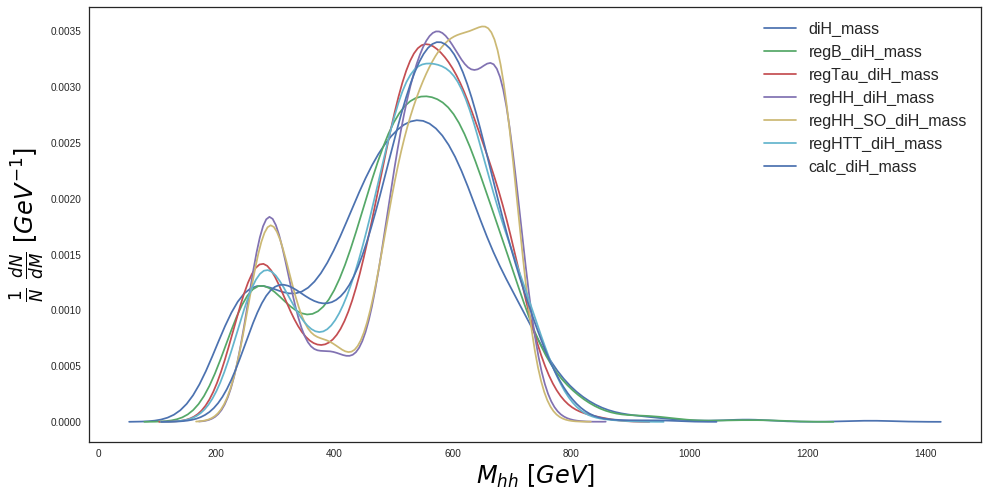

In [17]:
hist_params = {'shade' : False}
plt.figure(figsize=(16, 8))
sns.kdeplot(data=valData.loc[sig, 'diH_mass'])
sns.kdeplot(data=valData.loc[sig, 'regB_diH_mass'])
sns.kdeplot(data=valData.loc[sig, 'regTau_diH_mass'])
#sns.kdeplot(data=valData.loc[sig, 'gen_diH_mass'])
sns.kdeplot(data=valData.loc[sig, 'regHH_diH_mass'])
sns.kdeplot(data=valData.loc[sig, 'regHH_SO_diH_mass'])
sns.kdeplot(data=valData.loc[sig, 'regHTT_diH_mass'])
sns.kdeplot(data=valData.loc[sig, 'calc_diH_mass'])

plt.legend(fontsize=16)
plt.xlabel(r'$M_{hh}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

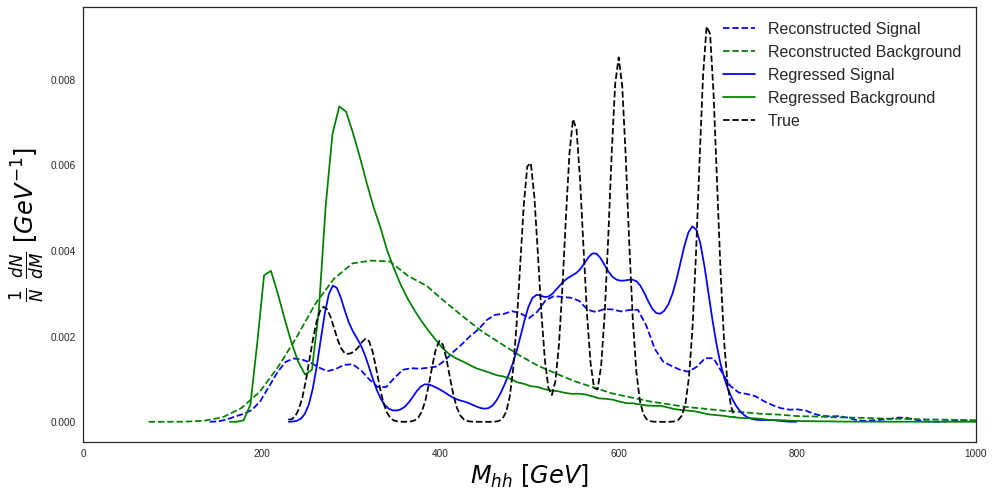

In [8]:
plt.figure(figsize=(16, 8))
sns.kdeplot(data=valData.loc[sig, 'diH_mass'], label = "Reconstructed Signal",bw = 10 , ls ='dashed', color = 'blue')
sns.kdeplot(data=valData.loc[bkg, 'diH_mass'],label = "Reconstructed Background",bw = 10,ls='dashed', color = 'green')
sns.kdeplot(data=valData.loc[sig, 'regHH_diH_mass'],label = "Regressed Signal",bw = 10 , color = 'blue')
sns.kdeplot(data=valData.loc[bkg, 'regHH_diH_mass'],label = "Regressed Background",bw = 5, color ='green')
sns.kdeplot(data=valData.loc[sig, 'gen_diH_mass'],label = "True", ls ='dashed',bw = 10, color = 'black')
#sns.kdeplot(data=valData.loc[sig, 'regB_diH_mass'], label = "B SO Regressor Signal", bw = 10, color = 'blue', ls= "dotted")
#sns.kdeplot(data=valData.loc[bkg, 'regB_diH_mass'], label = "B SO Regressor Background", bw = 10, color = 'green', ls="dotted")
#sns.kdeplot(data=valData.loc[sig, 'regTau_diH_mass'], label = "Tau SO Regressor Signal", bw = 10, color = 'blue', ls= "dashdot")
#sns.kdeplot(data=valData.loc[bkg, 'regTau_diH_mass'], label = "Tau SO Regressor Background", bw = 10, color = 'green', ls="dashdot")

plt.xlim(0,1000)
plt.legend(fontsize=16)
plt.xlabel(r'$M_{hh}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

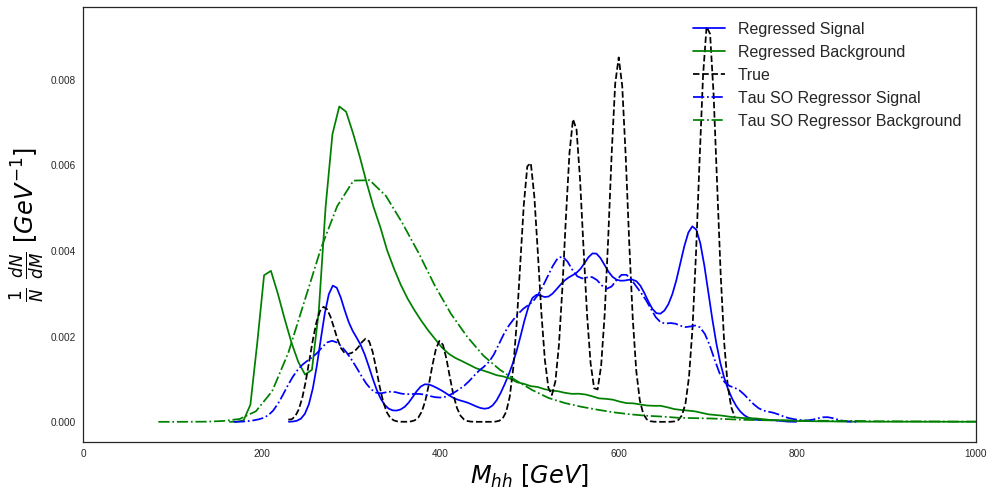

In [9]:
plt.figure(figsize=(16, 8))
#sns.kdeplot(data=valData.loc[sig, 'diH_mass'], label = "Reconstructed Signal",bw = 10 , ls ='dashed', color = 'blue')
#sns.kdeplot(data=valData.loc[bkg, 'diH_mass'],label = "Reconstructed Background",bw = 10,ls='dashed', color = 'green')
sns.kdeplot(data=valData.loc[sig, 'regHH_diH_mass'],label = "Regressed Signal",bw = 10 , color = 'blue')
sns.kdeplot(data=valData.loc[bkg, 'regHH_diH_mass'],label = "Regressed Background",bw = 5, color ='green')
sns.kdeplot(data=valData.loc[sig, 'gen_diH_mass'],label = "True", ls ='dashed',bw = 10, color = 'black')
#sns.kdeplot(data=valData.loc[sig, 'regB_diH_mass'], label = "B SO Regressor Signal", bw = 10, color = 'blue', ls= "dotted")
#sns.kdeplot(data=valData.loc[bkg, 'regB_diH_mass'], label = "B SO Regressor Background", bw = 10, color = 'green', ls="dotted")
sns.kdeplot(data=valData.loc[sig, 'regTau_diH_mass'], label = "Tau SO Regressor Signal", bw = 10, color = 'blue', ls= "dashdot")
sns.kdeplot(data=valData.loc[bkg, 'regTau_diH_mass'], label = "Tau SO Regressor Background", bw = 10, color = 'green', ls="dashdot")

plt.xlim(0,1000)
plt.legend(fontsize=16)
plt.xlabel(r'$M_{hh}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

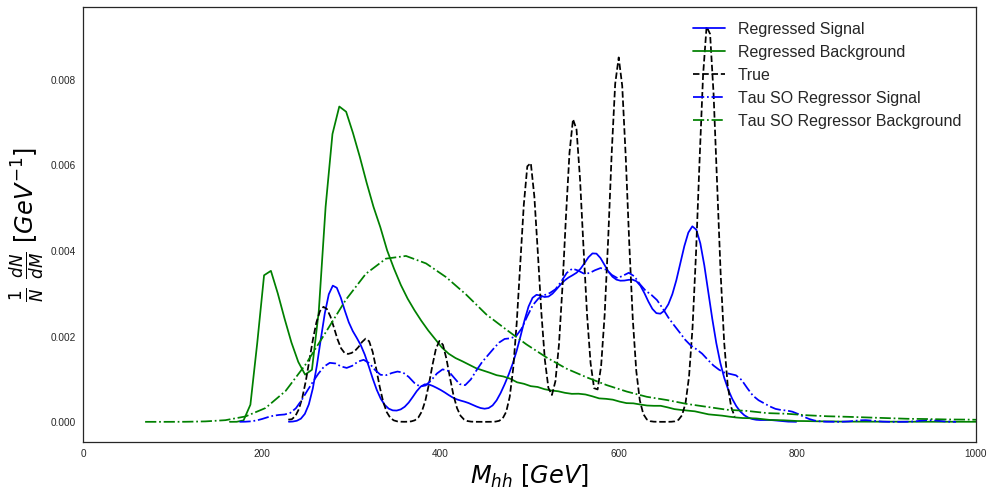

In [16]:
plt.figure(figsize=(16, 8))
#sns.kdeplot(data=valData.loc[sig, 'diH_mass'], label = "Reconstructed Signal",bw = 10 , ls ='dashed', color = 'blue')
#sns.kdeplot(data=valData.loc[bkg, 'diH_mass'],label = "Reconstructed Background",bw = 10,ls='dashed', color = 'green')
sns.kdeplot(data=valData.loc[sig, 'regHH_diH_mass'],label = "Regressed Signal",bw = 10 , color = 'blue')
sns.kdeplot(data=valData.loc[bkg, 'regHH_diH_mass'],label = "Regressed Background",bw = 5, color ='green')
sns.kdeplot(data=valData.loc[sig, 'gen_diH_mass'],label = "True", ls ='dashed',bw = 10, color = 'black')
#sns.kdeplot(data=valData.loc[sig, 'regB_diH_mass'], label = "B SO Regressor Signal", bw = 10, color = 'blue', ls= "dotted")
#sns.kdeplot(data=valData.loc[bkg, 'regB_diH_mass'], label = "B SO Regressor Background", bw = 10, color = 'green', ls="dotted")
#sns.kdeplot(data=valData.loc[sig, 'regTau_diH_mass'], label = "Tau SO Regressor Signal", bw = 10, color = 'blue', ls= "dashdot")
#sns.kdeplot(data=valData.loc[bkg, 'regTau_diH_mass'], label = "Tau SO Regressor Background", bw = 10, color = 'green', ls="dashdot")
sns.kdeplot(data=valData.loc[sig, 'regHTT_diH_mass'], label = "Tau SO Regressor Signal", bw = 10, color = 'blue', ls= "dashdot")
sns.kdeplot(data=valData.loc[bkg, 'regHTT_diH_mass'], label = "Tau SO Regressor Background", bw = 10, color = 'green', ls="dashdot")

plt.xlim(0,1000)
plt.legend(fontsize=16)
plt.xlabel(r'$M_{hh}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

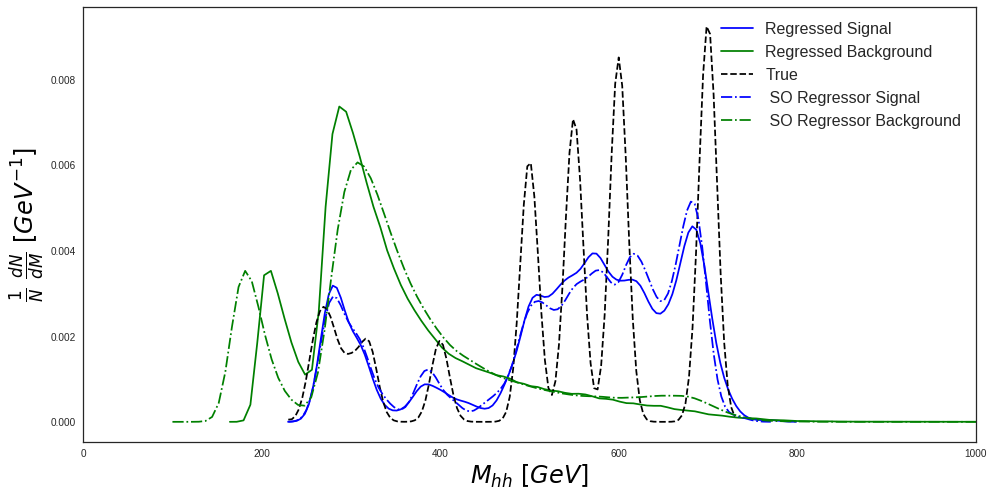

In [9]:
plt.figure(figsize=(16, 8))
#sns.kdeplot(data=valData.loc[sig, 'diH_mass'], label = "Reconstructed Signal",bw = 10 , ls ='dashed', color = 'blue')
#sns.kdeplot(data=valData.loc[bkg, 'diH_mass'],label = "Reconstructed Background",bw = 10,ls='dashed', color = 'green')
sns.kdeplot(data=valData.loc[sig, 'regHH_diH_mass'],label = "Regressed Signal",bw = 10 , color = 'blue')
sns.kdeplot(data=valData.loc[bkg, 'regHH_diH_mass'],label = "Regressed Background",bw = 5, color ='green')
sns.kdeplot(data=valData.loc[sig, 'gen_diH_mass'],label = "True", ls ='dashed',bw = 10, color = 'black')
#sns.kdeplot(data=valData.loc[sig, 'regB_diH_mass'], label = "B SO Regressor Signal", bw = 10, color = 'blue', ls= "dotted")
#sns.kdeplot(data=valData.loc[bkg, 'regB_diH_mass'], label = "B SO Regressor Background", bw = 10, color = 'green', ls="dotted")
#sns.kdeplot(data=valData.loc[sig, 'regTau_diH_mass'], label = "Tau SO Regressor Signal", bw = 10, color = 'blue', ls= "dashdot")
#sns.kdeplot(data=valData.loc[bkg, 'regTau_diH_mass'], label = "Tau SO Regressor Background", bw = 10, color = 'green', ls="dashdot")
sns.kdeplot(data=valData.loc[sig, 'regHH_SO_diH_mass'], label = " SO Regressor Signal", bw = 10, color = 'blue', ls= "dashdot")
sns.kdeplot(data=valData.loc[bkg, 'regHH_SO_diH_mass'], label = " SO Regressor Background", bw = 10, color = 'green', ls="dashdot")

plt.xlim(0,1000)
plt.legend(fontsize=16)
plt.xlabel(r'$M_{hh}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

In [ ]:
plt.figure(figsize=(16, 8))
#sns.kdeplot(data=valData.loc[sig, 'diH_mass'], label = "Reconstructed Signal",bw = 10 , ls ='dashed', color = 'blue')
#sns.kdeplot(data=valData.loc[bkg, 'diH_mass'],label = "Reconstructed Background",bw = 10,ls='dashed', color = 'green')
sns.kdeplot(data=valData.loc[sig, 'regHH_diH_mass'],label = "Regressed Signal",bw = 10 , color = 'blue')
sns.kdeplot(data=valData.loc[bkg, 'regHH_diH_mass'],label = "Regressed Background",bw = 5, color ='green')
sns.kdeplot(data=valData.loc[sig, 'gen_diH_mass'],label = "True", ls ='dashed',bw = 10, color = 'black')
#sns.kdeplot(data=valData.loc[sig, 'regB_diH_mass'], label = "B SO Regressor Signal", bw = 10, color = 'blue', ls= "dotted")
#sns.kdeplot(data=valData.loc[bkg, 'regB_diH_mass'], label = "B SO Regressor Background", bw = 10, color = 'green', ls="dotted")
#sns.kdeplot(data=valData.loc[sig, 'regTau_diH_mass'], label = "Tau SO Regressor Signal", bw = 10, color = 'blue', ls= "dashdot")
#sns.kdeplot(data=valData.loc[bkg, 'regTau_diH_mass'], label = "Tau SO Regressor Background", bw = 10, color = 'green', ls="dashdot")
sns.kdeplot(data=valData.loc[sig, 'regHH_SO_diH_mass'], label = " SO Regressor Signal", bw = 10, color = 'blue', ls= "dashdot")
sns.kdeplot(data=valData.loc[bkg, 'regHH_SO_diH_mass'], label = " SO Regressor Background", bw = 10, color = 'green', ls="dashdot")

plt.xlim(0,1000)
plt.legend(fontsize=16)
plt.xlabel(r'$M_{hh}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

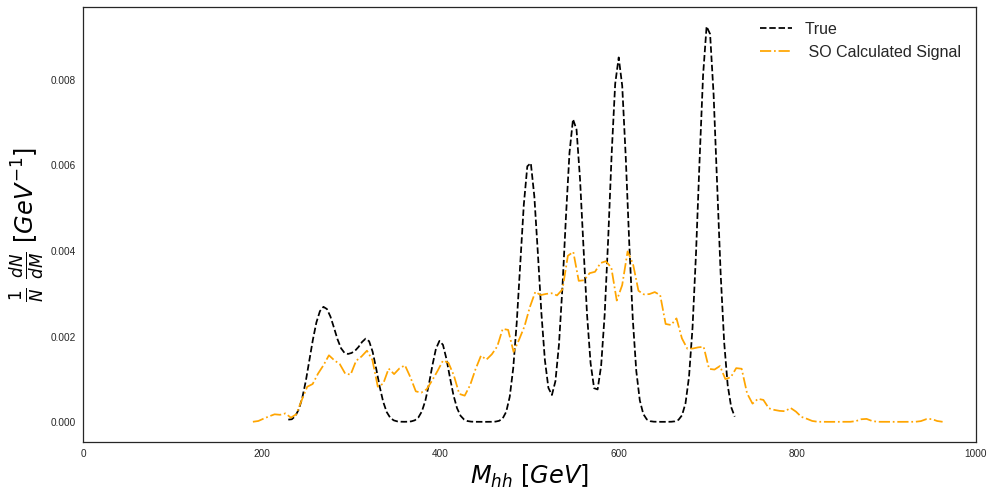

In [24]:
plt.figure(figsize=(16, 8))
#sns.kdeplot(data=valData.loc[sig, 'diH_mass'], label = "Reconstructed Signal",bw = 10 , ls ='dashed', color = 'blue')
#sns.kdeplot(data=valData.loc[bkg, 'diH_mass'],label = "Reconstructed Background",bw = 10,ls='dashed', color = 'green')
#sns.kdeplot(data=valData.loc[sig, 'regHH_diH_mass'],label = "Regressed Signal",bw = 10 , color = 'green')
#sns.kdeplot(data=valData.loc[bkg, 'regHH_diH_mass'],label = "Regressed Background",bw = 5, color ='green')
sns.kdeplot(data=valData.loc[sig, 'gen_diH_mass'],label = "True", ls ='dashed',bw = 10, color = 'black')
#sns.kdeplot(data=valData.loc[sig, 'regB_diH_mass'], label = "BRegressor Signal", bw = 10, color = 'red', ls= "dotted")
#sns.kdeplot(data=valData.loc[bkg, 'regB_diH_mass'], label = "B SO Regressor Background", bw = 10, color = 'green', ls="dotted")
#sns.kdeplot(data=valData.loc[sig, 'regHTT_diH_mass'], label = "Tau SO Regressor Signal", bw = 10, color = 'purple', ls= "dashdot")
#sns.kdeplot(data=valData.loc[bkg, 'regTau_diH_mass'], label = "Tau SO Regressor Background", bw = 10, color = 'green', ls="dashdot")
#sns.kdeplot(data=valData.loc[sig, 'regHH_SO_diH_mass'], label = " SO Regressor Signal", bw = 10, color = 'blue', ls= "dashdot")
sns.kdeplot(data=valData.loc[sig, 'calc_diH_mass'], label = " SO Calculated Signal", bw = 5, color = 'orange', ls= "dashdot")
plt.xlim(0,1000)
plt.legend(fontsize=16)
plt.xlabel(r'$M_{hh}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

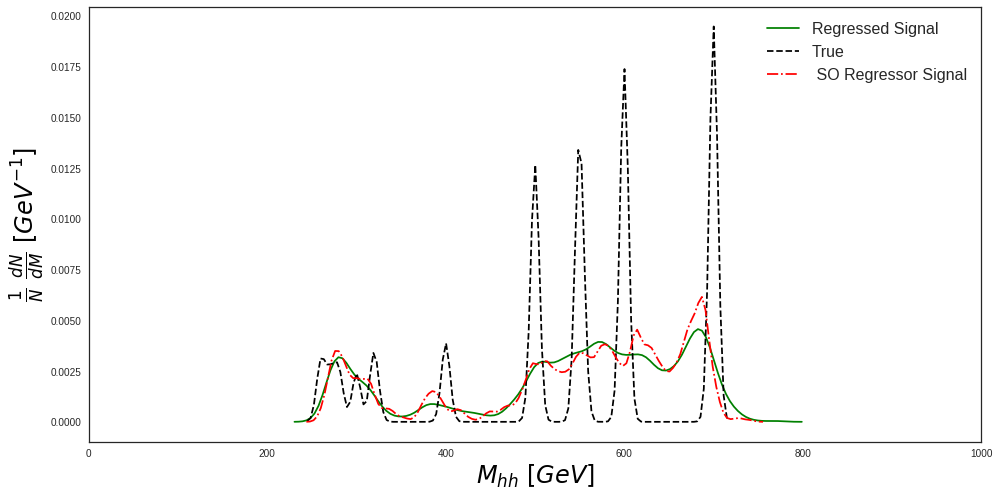

'calc_diH_mass'

In [28]:
plt.figure(figsize=(16, 8))
#sns.kdeplot(data=valData.loc[sig, 'diH_mass'], label = "Reconstructed Signal",bw = 10 , ls ='dashed', color = 'blue')
#sns.kdeplot(data=valData.loc[bkg, 'diH_mass'],label = "Reconstructed Background",bw = 10,ls='dashed', color = 'green')
sns.kdeplot(data=valData.loc[sig, 'regHH_diH_mass'],label = "Regressed Signal",bw = 10 , color = 'green')
#sns.kdeplot(data=valData.loc[bkg, 'regHH_diH_mass'],label = "Regressed Background",bw = 5, color ='green')
sns.kdeplot(data=valData.loc[sig, 'gen_diH_mass'],label = "True", ls ='dashed',bw = 5, color = 'black')
#sns.kdeplot(data=valData.loc[sig, 'regB_diH_mass'], label = "BRegressor Signal", bw = 10, color = 'red', ls= "dotted")
#sns.kdeplot(data=valData.loc[bkg, 'regB_diH_mass'], label = "B SO Regressor Background", bw = 10, color = 'green', ls="dotted")
#sns.kdeplot(data=valData.loc[sig, 'regHTT_diH_mass'], label = "Tau SO Regressor Signal", bw = 10, color = 'purple', ls= "dashdot")
#sns.kdeplot(data=valData.loc[bkg, 'regTau_diH_mass'], label = "Tau SO Regressor Background", bw = 10, color = 'green', ls="dashdot")
sns.kdeplot(data=valData.loc[sig, 'regHH_SO_diH_mass'], label = " SO Regressor Signal", bw = 5, color = 'red', ls= "dashdot")
#sns.kdeplot(data=valData.loc[sig, 'calc_diH_mass'], label = " SO Calculated Signal", bw = 10, color = 'orange', ls= "dashdot")

plt.xlim(0,1000)
plt.legend(fontsize=16)
plt.xlabel(r'$M_{hh}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()


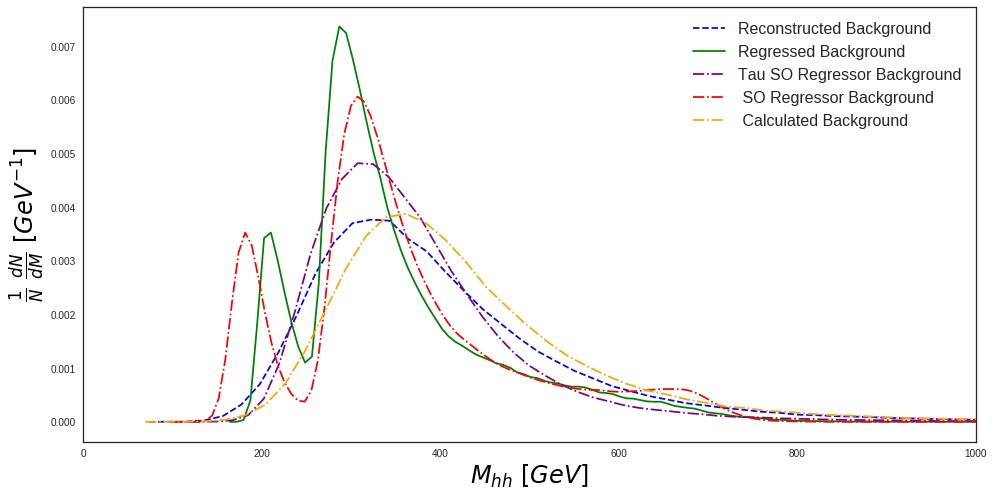

In [20]:
plt.figure(figsize=(16, 8))
#sns.kdeplot(data=valData.loc[sig, 'diH_mass'], label = "Reconstructed Signal",bw = 10 , ls ='dashed', color = 'blue')
sns.kdeplot(data=valData.loc[bkg, 'diH_mass'],label = "Reconstructed Background",bw = 10,ls='dashed', color = 'blue')
#sns.kdeplot(data=valData.loc[sig, 'regHH_diH_mass'],label = "Regressed Signal",bw = 10 , color = 'blue')
sns.kdeplot(data=valData.loc[bkg, 'regHH_diH_mass'],label = "Regressed Background",bw = 5, color ='green')
#sns.kdeplot(data=valData.loc[sig, 'gen_diH_mass'],label = "True", ls ='dashed',bw = 10, color = 'black')
#sns.kdeplot(data=valData.loc[sig, 'regB_diH_mass'], label = "B SO Regressor Signal", bw = 10, color = 'blue', ls= "dotted")
#sns.kdeplot(data=valData.loc[bkg, 'regB_diH_mass'], label = "B SO Regressor Background", bw = 10, color = 'red', ls="dotted")
#sns.kdeplot(data=valData.loc[sig, 'regTau_diH_mass'], label = "Tau SO Regressor Signal", bw = 10, color = 'blue', ls= "dashdot")
sns.kdeplot(data=valData.loc[bkg, 'regHTT_diH_mass'], label = "Tau SO Regressor Background", bw = 10, color = 'purple', ls="dashdot")
sns.kdeplot(data=valData.loc[bkg, 'regHH_SO_diH_mass'], label = " SO Regressor Background", bw = 10, color = 'red', ls="dashdot")
sns.kdeplot(data=valData.loc[bkg, 'calc_diH_mass'], label = " Calculated Background", bw = 10, color = 'orange', ls="dashdot")

plt.xlim(0,1000)
plt.legend(fontsize=16)
plt.xlabel(r'$M_{hh}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

### Delta distribution

260
Distribution		mean	sigma
Reconstructed Signal, Mean = -0.0808099255824 +- 0.00203568594627, sigma = 0.118076129459 +- 0.00132752910706
Regressed Signal, Mean = 0.0472331799664 +- 0.000479059031329, sigma = 0.0251215947406 +- 0.000416709647419
Regressed SO Signal,  Mean = 0.0466572242797 +- 0.000602426644947, sigma = 0.0299999334099 +- 0.000781360619178
Calculated SO Signal,  Mean = 0.104550252505 +- 0.00286075689275, sigma = 0.143588587385 +- 0.00145946042644


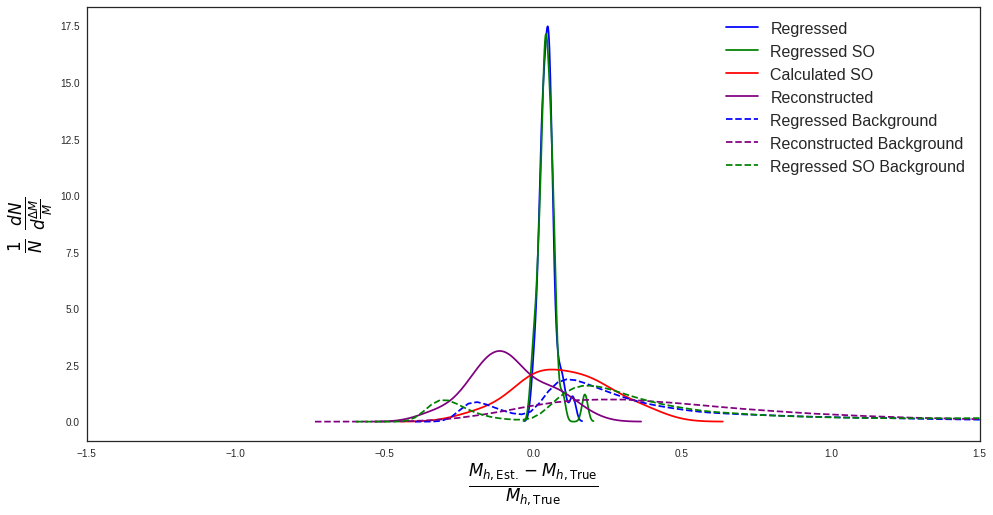

270
Distribution		mean	sigma
Reconstructed Signal, Mean = -0.0226260434517 +- 0.005080158778, sigma = 0.229996150613 +- 0.00796716588285
Regressed Signal, Mean = 0.0334667640233 +- 0.000338813673328, sigma = 0.0179205892194 +- 0.000249988356059
Regressed SO Signal,  Mean = 0.0416337134967 +- 0.000994639883214, sigma = 0.0445743649151 +- 0.00191425957574
Calculated SO Signal,  Mean = 0.127429667262 +- 0.00365396112331, sigma = 0.154119793578 +- 0.00217831149608


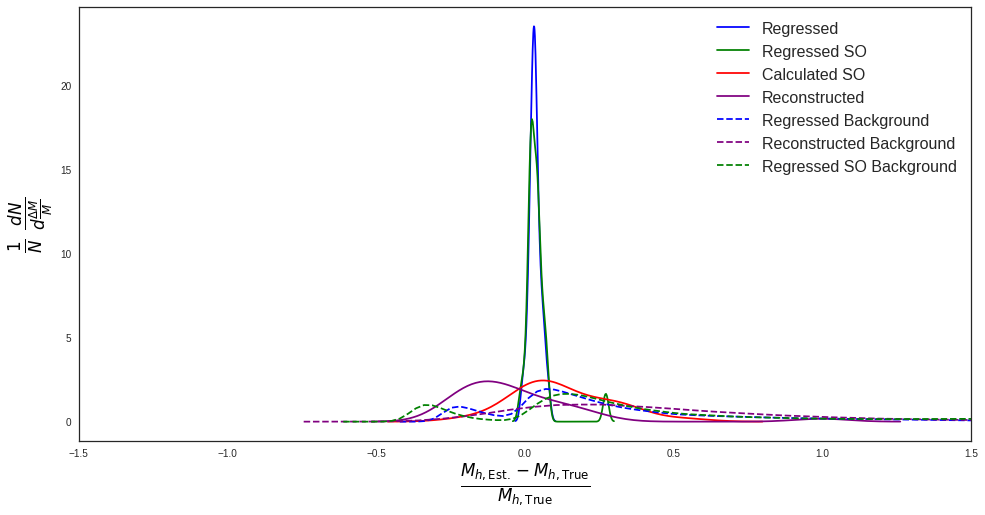

280
Distribution		mean	sigma
Reconstructed Signal, Mean = -0.066537849296 +- 0.00358967954208, sigma = 0.190788901009 +- 0.00289466782994
Regressed Signal, Mean = 0.0260909940686 +- 0.000554648616753, sigma = 0.0301899031909 +- 0.000483984309384
Regressed SO Signal,  Mean = 0.0331552683179 +- 0.000593643232192, sigma = 0.0331092782057 +- 0.000447362944912
Calculated SO Signal,  Mean = 0.0731141107602 +- 0.00225416864364, sigma = 0.127867944262 +- 0.00182324662237


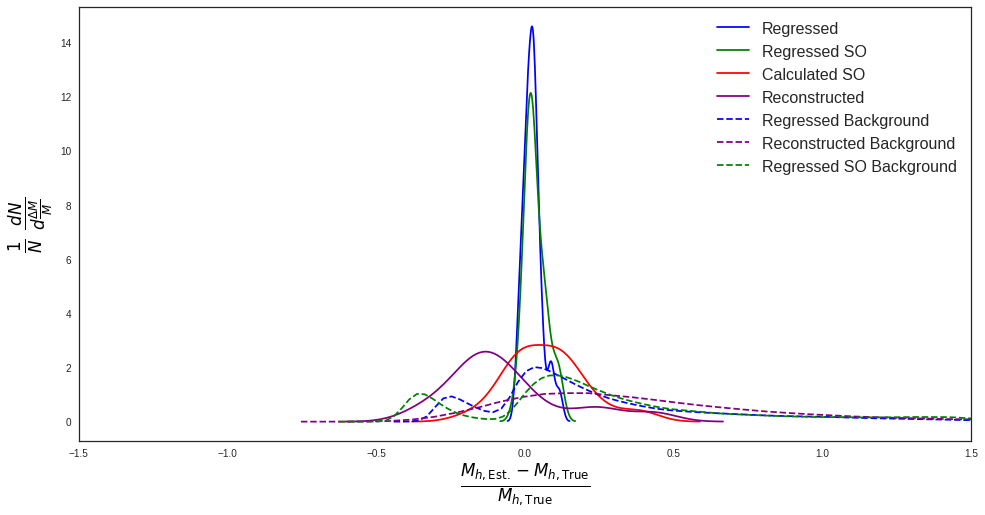

320
Distribution		mean	sigma
Reconstructed Signal, Mean = -0.0610712861814 +- 0.00215707180905, sigma = 0.159918223895 +- 0.00173381807643
Regressed Signal, Mean = -0.00687912871972 +- 0.000686025098885, sigma = 0.050993986568 +- 0.00060201730968
Regressed SO Signal,  Mean = -0.00633356026855 +- 0.000771571007885, sigma = 0.0481006248538 +- 0.000582934415572
Calculated SO Signal,  Mean = 0.0706318229406 +- 0.00185520714811, sigma = 0.133379737712 +- 0.00133239973807


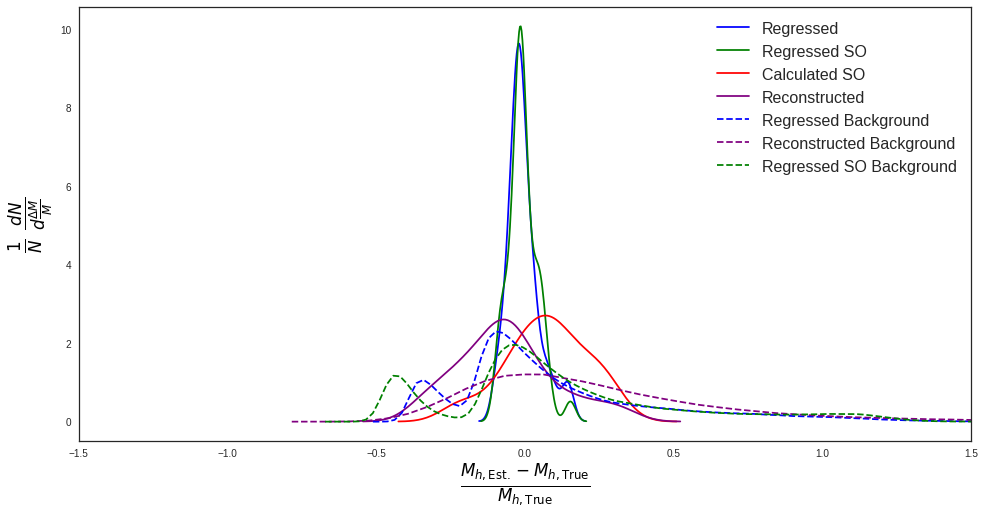

300
Distribution		mean	sigma
Reconstructed Signal, Mean = -0.0350087076208 +- 0.00281050741726, sigma = 0.158947490206 +- 0.00216965424146
Regressed Signal, Mean = 0.00902239261279 +- 0.00122329864489, sigma = 0.0681069950111 +- 0.00170395387469
Regressed SO Signal,  Mean = 0.0300649812479 +- 0.00156670764238, sigma = 0.087913449034 +- 0.00261259880466
Calculated SO Signal,  Mean = 0.0799137669319 +- 0.00277003034451, sigma = 0.1744915977 +- 0.00301593531035


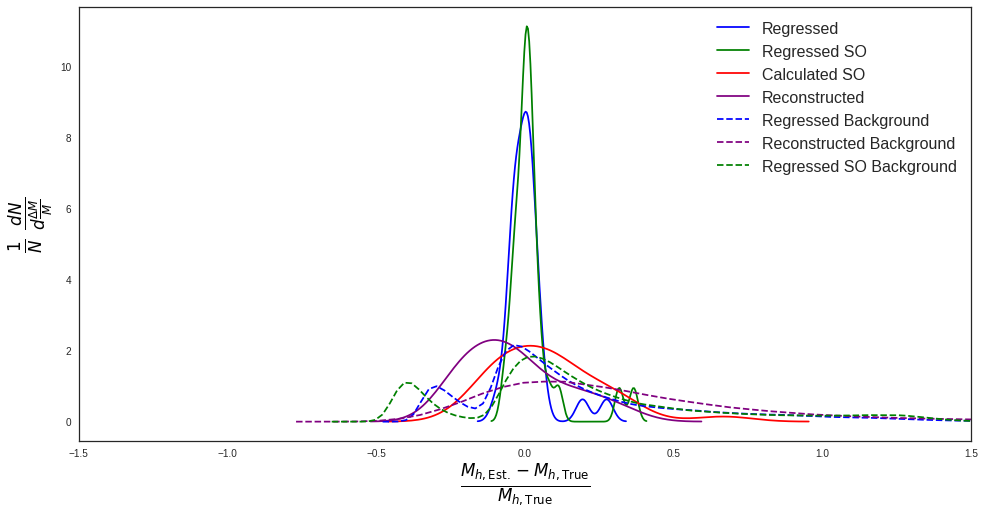

400
Distribution		mean	sigma
Reconstructed Signal, Mean = -0.0893805991391 +- 0.00173930790174, sigma = 0.127342780786 +- 0.00118126401329
Regressed Signal, Mean = -0.0105727100404 +- 0.00069279101995, sigma = 0.0537968288977 +- 0.000663681090074
Regressed SO Signal,  Mean = -0.0284166702331 +- 0.000563487558821, sigma = 0.0399390414909 +- 0.000496773066407
Calculated SO Signal,  Mean = 0.0301816358222 +- 0.00151248916431, sigma = 0.103162576446 +- 0.000972449531253


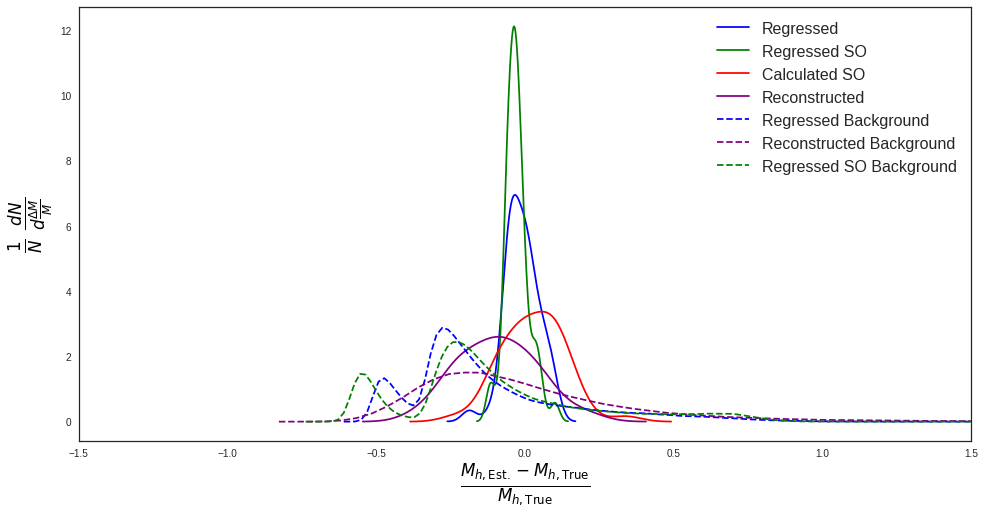

500
Distribution		mean	sigma
Reconstructed Signal, Mean = -0.0801132419704 +- 0.00153008671247, sigma = 0.181211600872 +- 0.00441111781084
Regressed Signal, Mean = 0.0201354801702 +- 0.000454499528135, sigma = 0.0605838078337 +- 0.000518443494153
Regressed SO Signal,  Mean = 0.0126330206468 +- 0.00054709623793, sigma = 0.0705858141417 +- 0.000635985146795
Calculated SO Signal,  Mean = 0.0124434640542 +- 0.000816655431841, sigma = 0.119686499155 +- 0.00178937006136


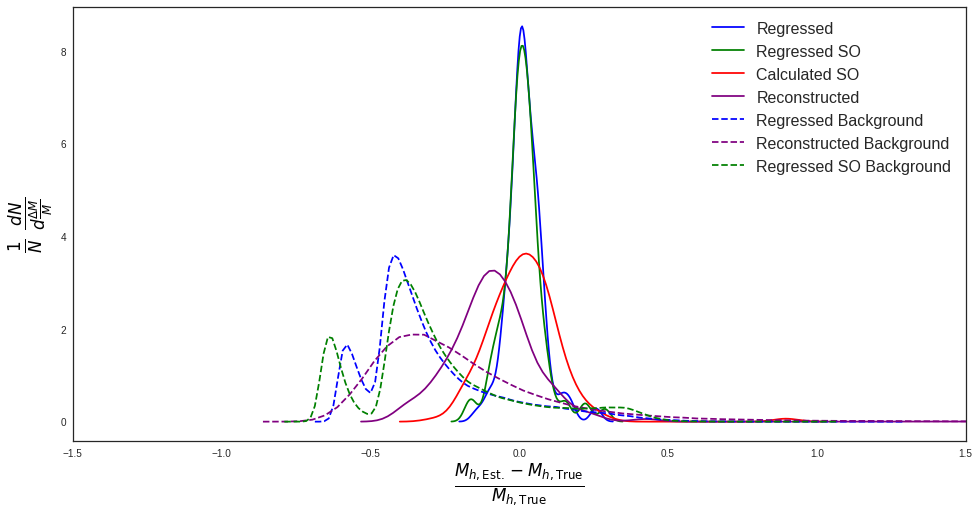

550
Distribution		mean	sigma
Reconstructed Signal, Mean = -0.0457188642006 +- 0.00123351391919, sigma = 0.145451980356 +- 0.00118018100376
Regressed Signal, Mean = 0.0200550653616 +- 0.000385362009637, sigma = 0.0584467739972 +- 0.000531883813498
Regressed SO Signal,  Mean = 0.0228906762455 +- 0.000471858294556, sigma = 0.0603288453238 +- 0.000546519961907
Calculated SO Signal,  Mean = -0.000802120172938 +- 0.000827300129111, sigma = 0.101125465817 +- 0.000659654789766


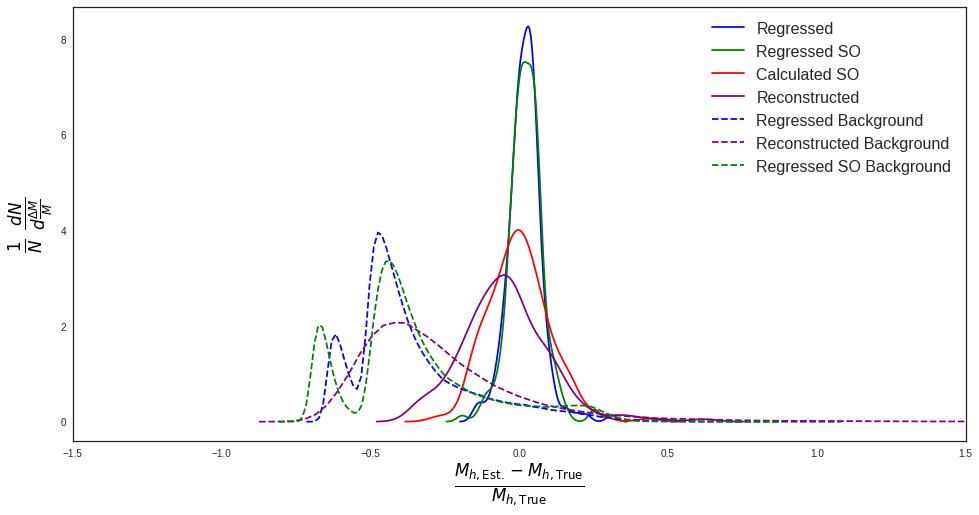

600
Distribution		mean	sigma
Reconstructed Signal, Mean = -0.0633708177861 +- 0.00116845499016, sigma = 0.163606878924 +- 0.0015432361243
Regressed Signal, Mean = 0.0125761411134 +- 0.000353863337028, sigma = 0.0551849170216 +- 0.000476701963544
Regressed SO Signal,  Mean = 0.0193379611761 +- 0.000356829244378, sigma = 0.0514301769321 +- 0.000516826634411
Calculated SO Signal,  Mean = -0.0197215112101 +- 0.00069119873554, sigma = 0.107178316049 +- 0.000858405812796


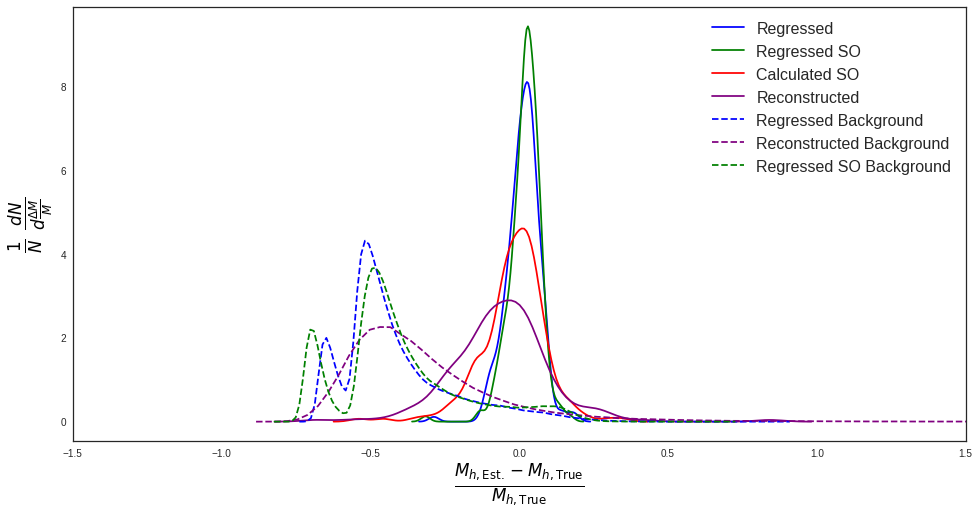

700
Distribution		mean	sigma
Reconstructed Signal, Mean = -0.0763657914034 +- 0.000987675655264, sigma = 0.138443079878 +- 0.000889275084954
Regressed Signal, Mean = -0.0281785296569 +- 0.000205082445188, sigma = 0.0336786856316 +- 0.000257183307724
Regressed SO Signal,  Mean = -0.0337046685823 +- 0.000184086805071, sigma = 0.0292778573421 +- 0.000288106781941
Calculated SO Signal,  Mean = -0.0554133254737 +- 0.000643536450761, sigma = 0.0922593402503 +- 0.000555444320097


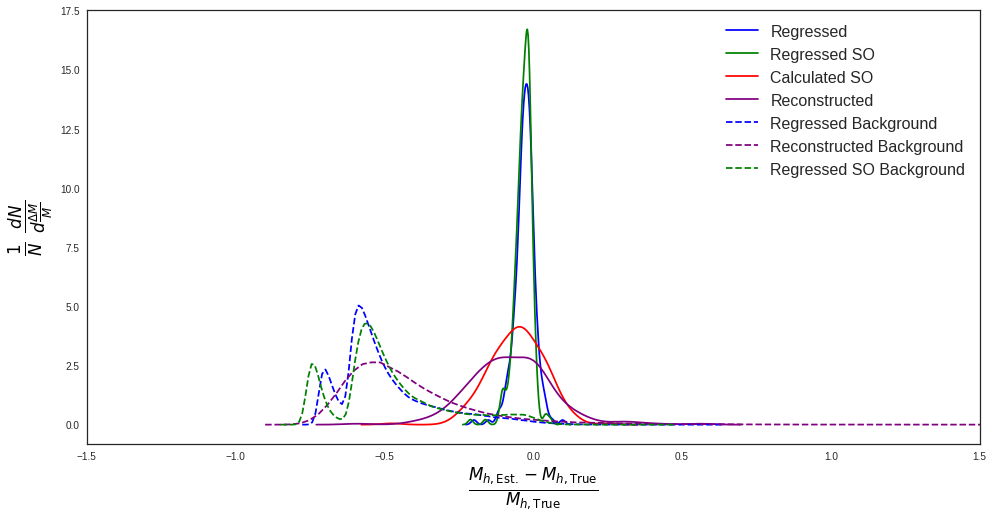

In [53]:

for energy in energies:
    plt.figure(figsize=(16, 8))
    print(energy)
    xPlot = np.linspace(-0.5, 0.5, 500)[:, np.newaxis]
    bootReg = []
    meanBootReg = []
    stdevBootReg = []
    for i in range(100):
        points = np.random.choice((valData[sig][valData[sig]['gen_label'] == float(energy)]['regHH_diH_mass'].values-float(energy))/float(energy), len(valData[sig][valData[sig]['gen_label'] == float(energy)]), replace=True)
        meanBootReg.append(points.mean())
        stdevBootReg.append(points.std())

    meanReg = (np.mean(meanBootReg), np.std(meanBootReg)/math.sqrt(len(meanBootReg)))
    stdevReg = (np.mean(stdevBootReg), np.std(stdevBootReg)/math.sqrt(len(stdevBootReg)))
    
      #bootBac = []
     #meanBootBac = []
    #stdevBootBac = []
   # for i in range(100):
  #      points = np.random.choice((valData[bkg]['regHH_diH_mass'].values-float(energy))/float(energy), len(valData[bkg]), replace=True)
 #       meanBootBac.append(points.mean())
#        stdevBootBac.append(points.std())

   # meanBac = (np.mean(meanBootBac), np.std(meanBootBac)/math.sqrt(len(meanBootBac)))
   # stdevBac = (np.mean(stdevBootBac), np.std(stdevBootBac)/math.sqrt(len(stdevBootBac)))
    
    
    bootRegSO = []
    meanBootRegSO = []
    stdevBootRegSO = []
    for i in range(100):
        points = np.random.choice((valData[sig][valData[sig]['gen_label'] == float(energy)]['regHH_SO_diH_mass'].values-float(energy))/float(energy), len(valData[sig][valData[sig]['gen_label'] == float(energy)]), replace=True)
        meanBootRegSO.append(points.mean())
        stdevBootRegSO.append(points.std())

    meanRegSO = (np.mean(meanBootRegSO), np.std(meanBootRegSO)/math.sqrt(len(meanBootRegSO)))
    stdevRegSO = (np.mean(stdevBootRegSO), np.std(stdevBootRegSO)/math.sqrt(len(stdevBootRegSO)))
    bootCalc = []
    meanBootCalc = []
    stdevBootCalc = []
    for i in range(100):
        points = np.random.choice((valData[sig][valData[sig]['gen_label'] == float(energy)]['calc_diH_mass'].values-float(energy))/float(energy), len(valData[sig][valData[sig]['gen_label'] == float(energy)]), replace=True)
        meanBootCalc.append(points.mean())
        stdevBootCalc.append(points.std())

    meanCalc = (np.mean(meanBootCalc), np.std(meanBootCalc)/math.sqrt(len(meanBootCalc)))
    stdevCalc = (np.mean(stdevBootCalc), np.std(stdevBootCalc)/math.sqrt(len(stdevBootCalc)))
    
    bootReco = []
    meanBootReco = []
    stdevBootReco = []
    for i in range(100):
        points = np.random.choice((valData[sig][valData[sig]['gen_label'] == float(energy)]['diH_mass'].values-float(energy))/float(energy), len(valData[sig][valData[sig]['gen_label'] == float(energy)]), replace=True)
        meanBootReco.append(points.mean())
        stdevBootReco.append(points.std())

    meanReco = (np.mean(meanBootReco), np.std(meanBootReco)/math.sqrt(len(meanBootReco)))
    stdevReco = (np.mean(stdevBootReco), np.std(stdevBootReco)/math.sqrt(len(stdevBootReco)))
    print("Distribution\t\tmean\tsigma")
    print('Reconstructed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanReco[0], meanReco[1], stdevReco[0], stdevReco[1]))
    print('Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanReg[0], meanReg[1], stdevReg[0], stdevReg[1]))
    print('Regressed SO Signal,  Mean = {} +- {}, sigma = {} +- {}'.format(meanRegSO[0], meanRegSO[1], stdevRegSO[0], stdevRegSO[1]))
    print('Calculated SO Signal,  Mean = {} +- {}, sigma = {} +- {}'.format(meanCalc[0], meanCalc[1], stdevCalc[0], stdevCalc[1]))
    hist_params = {'shade' : False}
    
    sns.kdeplot(data=(valData[sig][valData[sig]['gen_label'] == float(energy)]['regHH_diH_mass'].values-float(energy))/float(energy),color="blue", label='Regressed')
    sns.kdeplot(data=(valData[sig][valData[sig]['gen_label'] == float(energy)]['regHH_SO_diH_mass'].values-float(energy))/float(energy),color ="green", label='Regressed SO')
    sns.kdeplot(data=(valData[sig][valData[sig]['gen_label'] == float(energy)]['calc_diH_mass'].values-float(energy))/float(energy),color="red",label='Calculated SO')
    sns.kdeplot(data=(valData[sig][valData[sig]['gen_label'] == float(energy)]['diH_mass'].values-float(energy))/float(energy),color = "purple", label='Reconstructed')
    sns.kdeplot(data=(valData[bkg]['regHH_diH_mass'].values-float(energy))/float(energy),color="blue", ls = 'dashed', label='Regressed Background')
    sns.kdeplot(data=(valData[bkg]['diH_mass'].values-float(energy))/float(energy),color="purple",ls='dashed', label='Reconstructed Background')
    sns.kdeplot(data=(valData[bkg]['regHH_SO_diH_mass'].values-float(energy))/float(energy),color="green",ls="dashed", label='Regressed SO Background')

    plt.legend(fontsize=16)
    plt.xlim(-1.5,1.5)
    plt.xlabel(r"$\frac{M_{h,\mathrm{Est.}}-M_{h,\mathrm{True}}}{M_{h,\mathrm{True}}}$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\frac{\Delta M}{M}}$", fontsize=24, color='black')
    plt.show()


## Classifier response

### Train

In [ ]:
classFeatures = ['b_0_mass',
                 'b_1_mass',
                 't_0_mass',
                 't_1_mass',
                 'mPT_px', 'mPT_py',
                 'hl_mT']

In [ ]:
    """recoFeatures = ['b_0_px', 'b_0_py', 'b_0_pz', 'b_0_|p|', 'b_0_E',
                    'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_|p|', 'b_1_E',
                    't_0_px', 't_0_py', 't_0_pz', 't_0_E', 't_0_|p|',
                    't_1_px', 't_1_py', 't_1_pz', 't_1_E', 't_1_|p|',
                    'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_mass', 'h_bb_|p|', 'h_bb_E',
                    'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_mass', 'h_tt_E', 'h_tt_|p|',
                    'diH_px', 'diH_py', 'diH_pz', 'diH_mass', 'diH_E', 'diH_|p|']
    recoFeatures += classFeatures
    print len(recoFeatures), "Training features"
    recoClass = XGBoostClassifier()
    recoClass.fit(devData[recoFeatures], devData['gen_target'].values.astype('int'))"""

In [ ]:
"""regFeatures = ['regB_b_0_px', 'regB_b_0_py', 'regB_b_0_pz', 'regB_b_0_|p|', 'regB_b_0_E',
               'regB_b_1_px', 'regB_b_1_py', 'regB_b_1_pz', 'regB_b_1_|p|', 'regB_b_1_E',
               'regTau_t_0_px', 'regTau_t_0_py', 'regTau_t_0_pz', 'regTau_t_0_E', 'regTau_t_0_|p|',
               'regTau_t_1_px', 'regTau_t_1_py', 'regTau_t_1_pz', 'regTau_t_1_E', 'regTau_t_1_|p|',
               'regB_h_bb_px', 'regB_h_bb_py', 'regB_h_bb_pz', 'regHBB_h_bb_mass', 'regB_h_bb_|p|', 'regB_h_bb_E',
               'regTau_h_tt_px', 'regTau_h_tt_py', 'regTau_h_tt_pz', 'regHTT_h_tt_mass', 'regTau_h_tt_E', 'regTau_h_tt_|p|',
               'regHH_diH_px', 'regHH_diH_py', 'regHH_diH_pz', 'regHH_diH_mass', 'regHH_diH_E', 'regHH_diH_|p|']
regFeatures += classFeatures
print len(regFeatures), "Training features"
regClass = XGBoostClassifier()
regClass.fit(devData[regFeatures], devData['gen_target'].values.astype('int'))"""

### Test

In [ ]:
recoPred = [recoClass.predict_proba(devData[recoFeatures])[:,1],
            recoClass.predict_proba(valData[recoFeatures])[:,1]]

In [ ]:
regPred = [regClass.predict_proba(devData[regFeatures])[:,1],
           regClass.predict_proba(valData[regFeatures])[:,1]]

In [ ]:
recoAUC = [roc_auc_score(devData['gen_target'].values, recoPred[0]),
           roc_auc_score(valData['gen_target'].values, recoPred[1])]
regAUC = [roc_auc_score(devData['gen_target'].values, regPred[0]),
          roc_auc_score(valData['gen_target'].values, regPred[1])]

In [ ]:
plt.figure(figsize=[8, 8])
plt.plot(*roc_curve(devData['gen_target'].values, recoPred[0])[:2],
         label=r'Reco Dev, $auc={:.4f}$'.format(recoAUC[0]), linestyle='dashed', color='g')
plt.plot(*roc_curve(valData['gen_target'].values, recoPred[1])[:2],
         label=r'Reco Val, $auc={:.4f}$'.format(recoAUC[1]), color='g')
plt.plot(*roc_curve(devData['gen_target'].values, regPred[0])[:2],
         label=r'Reg Dev, $auc={:.4f}$'.format(regAUC[0]), linestyle='dashed', color='b')
plt.plot(*roc_curve(valData['gen_target'].values, regPred[1])[:2],
         label=r'Reg Val, $auc={:.4f}$'.format(regAUC[1]), color='b')
#plt.plot([0, 1], [0, 1], 'k--', label='No discrimination')
plt.xlabel('Background acceptance', fontsize=24, color='black')
plt.ylabel('Signal acceptance', fontsize=24, color='black')
plt.legend(loc='best', fontsize=24)
plt.show()

# Save selected data

In [ ]:
regFeatures = ['regB_b_0_px', 'regB_b_0_py', 'regB_b_0_pz', 'regB_b_0_|p|', 'regB_b_0_E',
               'regB_b_1_px', 'regB_b_1_py', 'regB_b_1_pz', 'regB_b_1_|p|', 'regB_b_1_E',
               'regTau_t_0_px', 'regTau_t_0_py', 'regTau_t_0_pz', 'regTau_t_0_E', 'regTau_t_0_|p|',
               'regTau_t_1_px', 'regTau_t_1_py', 'regTau_t_1_pz', 'regTau_t_1_E', 'regTau_t_1_|p|',
               'regB_h_bb_px', 'regB_h_bb_py', 'regB_h_bb_pz', 'regHBB_h_bb_mass', 'regB_h_bb_|p|', 'regB_h_bb_E',
               'regTau_h_tt_px', 'regTau_h_tt_py', 'regTau_h_tt_pz', 'regHTT_h_tt_mass', 'regTau_h_tt_E', 'regTau_h_tt_|p|',
               'regHH_diH_px', 'regHH_diH_py', 'regHH_diH_pz', 'regHH_diH_mass', 'regHH_diH_E', 'regHH_diH_|p|']

In [ ]:
cutData = data.copy()

In [ ]:
len(cutData.columns), [x for x in cutData.columns]

In [ ]:
cutFeats = [x for x in cutData.columns if '.1' in x]
print len(cutFeats), cutFeats

In [ ]:
cutData.drop(cutFeats, axis=1, inplace=True)

In [ ]:
cutFeats = [x for x in cutData.columns if 'phi' in x or 'eta' in x or 'pT' in x]
print len(cutFeats), cutFeats

In [ ]:
cutData.drop(cutFeats, axis=1, inplace=True)

In [ ]:
len(cutData.columns), [x for x in cutData.columns]

In [ ]:
cutFeats = [x for x in cutData.columns if 'hl_d' in x]
print len(cutFeats), [x for x in cutData.columns]

In [ ]:
cutData.drop(cutFeats, axis=1, inplace=True)

In [ ]:
len(cutData.columns), [x for x in cutData.columns]

In [ ]:
rename = [var for var in cutData.columns if var in regFeatures]
cutData.rename(columns=dict(zip(rename, ["reg" + var[var.find('_'):] for var in rename])), inplace=True)

In [ ]:
cutFeats = [x for x in cutData.columns if 'reg' in x and 'reg_' not in x]
print len(cutFeats), cutFeats

In [ ]:
cutData.drop(cutFeats, axis=1, inplace=True)

In [ ]:
len(cutData.columns), [x for x in cutData.columns]

In [ ]:
cutData.to_csv('/home/giles/cernbox/sample_analysis/processedData.csv')